In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import math
#import numdifftools as nd
import pandas as pd
#import pymc3 as pm

from tqdm import tqdm
from sklearn import preprocessing
from numpy.linalg import multi_dot
import scipy
import scipy.stats as ss
from scipy.stats import invgamma
from scipy.special import gamma
from scipy.special import digamma
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import levy_stable
from scipy.stats import gaussian_kde
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import sklearn.mixture
from scipy.linalg import sqrtm

import logging
import warnings
from functools import partial

logger = logging.getLogger(__name__)

c:\Users\nngu8343\AppData\Local\miniconda3\envs\vbsl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
## Generate actual data
def toad(alpha,
         gamma,
         p0,
         n_toads=66,
         n_days=63,
         batch_size=1,
         random_state=None):
    """Sample the movement of Fowler's toad species.
    Models foraging steps using a levy_stable distribution where individuals
    either return to a previous site or establish a new one.
    References
    ----------
    Marchand, P., Boenke, M., and Green, D. M. (2017).
    A stochastic movement model reproduces patterns of site fidelity and long-
    distance dispersal in a population of fowlers toads (anaxyrus fowleri).
    Ecological Modelling,360:63–69.
    Parameters
    ----------
    alpha : float or array_like with batch_size entries
        step length distribution stability parameter
    gamma : float or array_like with batch_size entries
        step lentgh distribution scale parameter
    p0 : float or array_like with batch_size entries
        probability of returning to a previous refuge site
    n_toads : int, optional
        number of toads
    n_days : int, optional
        number of days
    batch_size : int, optional
    random_state : RandomState, optional
    Returns
    -------
    np.ndarray in shape (n_days x n_toads x batch_size)
    """
    X = np.zeros((n_days, n_toads, batch_size))
    random_state = random_state or np.random
    step_gen = ss.levy_stable
    step_gen.random_state = random_state

    for i in range(1, n_days):
        ret = random_state.uniform(0, 1, (n_toads, batch_size)) < np.squeeze(p0)
        non_ret = np.invert(ret)

        delta_x = step_gen.rvs(alpha, beta=0, scale=gamma, size=(n_toads, batch_size))
        X[i, non_ret] = X[i-1, non_ret] + delta_x[non_ret]

        ind_refuge = random_state.choice(i, size=(n_toads, batch_size))
        X[i, ret] = X[ind_refuge[ret], ret]

    return X


def compute_summaries(X, lag, p=np.linspace(0, 1, 3), thd=10):
    """Compute summaries for toad model.
    For displacements over lag...
        Log of the differences in the p quantiles
        The number of absolute displacements less than thd
        Median of the absolute displacements greater than thd
    Parameters
    ----------
    X : np.array of shape (ndays x ntoads x batch_size)
        observed matrix of toad displacements
    lag : list of ints, optional
        the number of days behind to compute displacement with
    p : np.array, optional
        quantiles used in summary statistic calculation (default 0, 0.1, ... 1)
    thd : float
        toads are considered returned when absolute displacement does not exceed thd (default 10m)
    Returns
    -------
    np.ndarray in shape (batch_size x len(p) + 1)
    """
    disp = obs_mat_to_deltax(X, lag)  # num disp at lag x batch size
    abs_disp = np.abs(disp)
    # returned toads
    ret = abs_disp < thd
    num_ret = np.sum(ret, axis=0)
    # non-returned toads
    abs_disp[ret] = np.nan  # ignore returned toads
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN slice encountered')
        # abs_noret_median = np.nanmedian(abs_disp, axis=0)
        abs_noret_quantiles = np.nanquantile(abs_disp, p, axis=0)
    diff = np.diff(abs_noret_quantiles, axis=0)
    logdiff = np.log(np.maximum(diff, np.exp(-20)))  # substitute zeros with a small positive
    # combine
    # ssx = np.vstack((num_ret, abs_noret_median, logdiff))
    ssx = np.vstack((np.log(num_ret), logdiff))
    ssx = np.nan_to_num(ssx, nan=np.inf)  # nans are when all toads returned
    return np.transpose(ssx)


def obs_mat_to_deltax(X, lag):
    """Convert an observation matrix to a vector of displacements.
    Parameters
    ----------
    X : np.array (n_days x n_toads x batch_size)
        observed matrix of toad displacements
    lag : int
        the number of days behind to compute displacement with
    Returns
    -------
    np.ndarray in shape (n_toads * (n_days - lag) x batch_size)
    """
    batch_size = np.atleast_3d(X).shape[-1]
    return (X[lag:] - X[:-lag]).reshape(-1, batch_size)

In [3]:
true_theta = np.array([1.7, 35.0, 0.6])

In [4]:
actual_data = toad(true_theta[0], true_theta[1], true_theta[2])
actual_data

array([[[   0.        ],
        [   0.        ],
        [   0.        ],
        ...,
        [   0.        ],
        [   0.        ],
        [   0.        ]],

       [[  31.67936691],
        [   0.        ],
        [   0.        ],
        ...,
        [  -0.85787572],
        [  33.26302356],
        [   0.        ]],

       [[  19.7297545 ],
        [ -98.06562551],
        [ -10.6807681 ],
        ...,
        [   0.        ],
        [ 103.48341696],
        [   0.64248206]],

       ...,

       [[  -5.87140399],
        [  -0.62603343],
        [ -10.6807681 ],
        ...,
        [   0.        ],
        [-244.64632354],
        [  42.30879062]],

       [[ -24.27400471],
        [  21.51268053],
        [  36.20471276],
        ...,
        [ -85.83679976],
        [-273.21195325],
        [  -9.74915024]],

       [[  -5.87140399],
        [ -37.12961261],
        [  50.38107164],
        ...,
        [ -86.01313962],
        [-333.57644587],
        [  -2.53624824]]

In [5]:
lags = [1, 2, 4, 8]
num_coeffs = 3
num_latent = 12
num_datasets = 200
n_samples = 500
sigma_latent = 1
sigma_theta = 10
eps_precision = 100

In [6]:
def compute_summaries_stacked(X, lags):
    S1 = compute_summaries(X, lags[0])
    S2 = compute_summaries(X, lags[1])
    S4 = compute_summaries(X, lags[2])
    S8 = compute_summaries(X, lags[3])
    return np.hstack((S1, S2, S4, S8))

In [7]:
actual_summary_statistics = compute_summaries_stacked(actual_data, lags)[0]
actual_summary_statistics

array([6.91473089, 3.58013081, 7.66242288, 6.81234509, 3.8503222 ,
       7.67454775, 6.68336095, 3.96031306, 7.56779179, 6.58063914,
       3.92235841, 7.62194323])

In [8]:
#Store the values for consistency
actual_summary_statistics = np.array([6.9246124 , 3.66996993, 6.30071171, 6.7178047 , 3.91656951,
       6.31433913, 6.66185474, 4.03792021, 6.47012367, 6.50578406,
       4.0408775 , 6.33987272])

In [9]:
def my_inv(x):
    return np.linalg.inv(x + (np.eye(x.shape[0]) * 1e-7))

In [10]:
# Generating data to train the transform
wass_datasets = toad(true_theta[0], true_theta[1], true_theta[2],batch_size=3000)
wass_n_summary_statistics = np.array([compute_summaries_stacked(wass_datasets[:,:,i], lags)[0] for i in range(3000)])

In [11]:
# Divide the synthetic data to train, test, val
wass_train_summary_statistics = wass_n_summary_statistics[:int(3000/3),:]
wass_val_summary_statistics = wass_n_summary_statistics[int(3000/3):int(3000 * 2/3),:]
wass_test_summary_statistics = wass_n_summary_statistics[int(3000 * 2/3):3000,:]

original_train_summary_statistics = wass_train_summary_statistics
original_test_summary_statistics = wass_test_summary_statistics

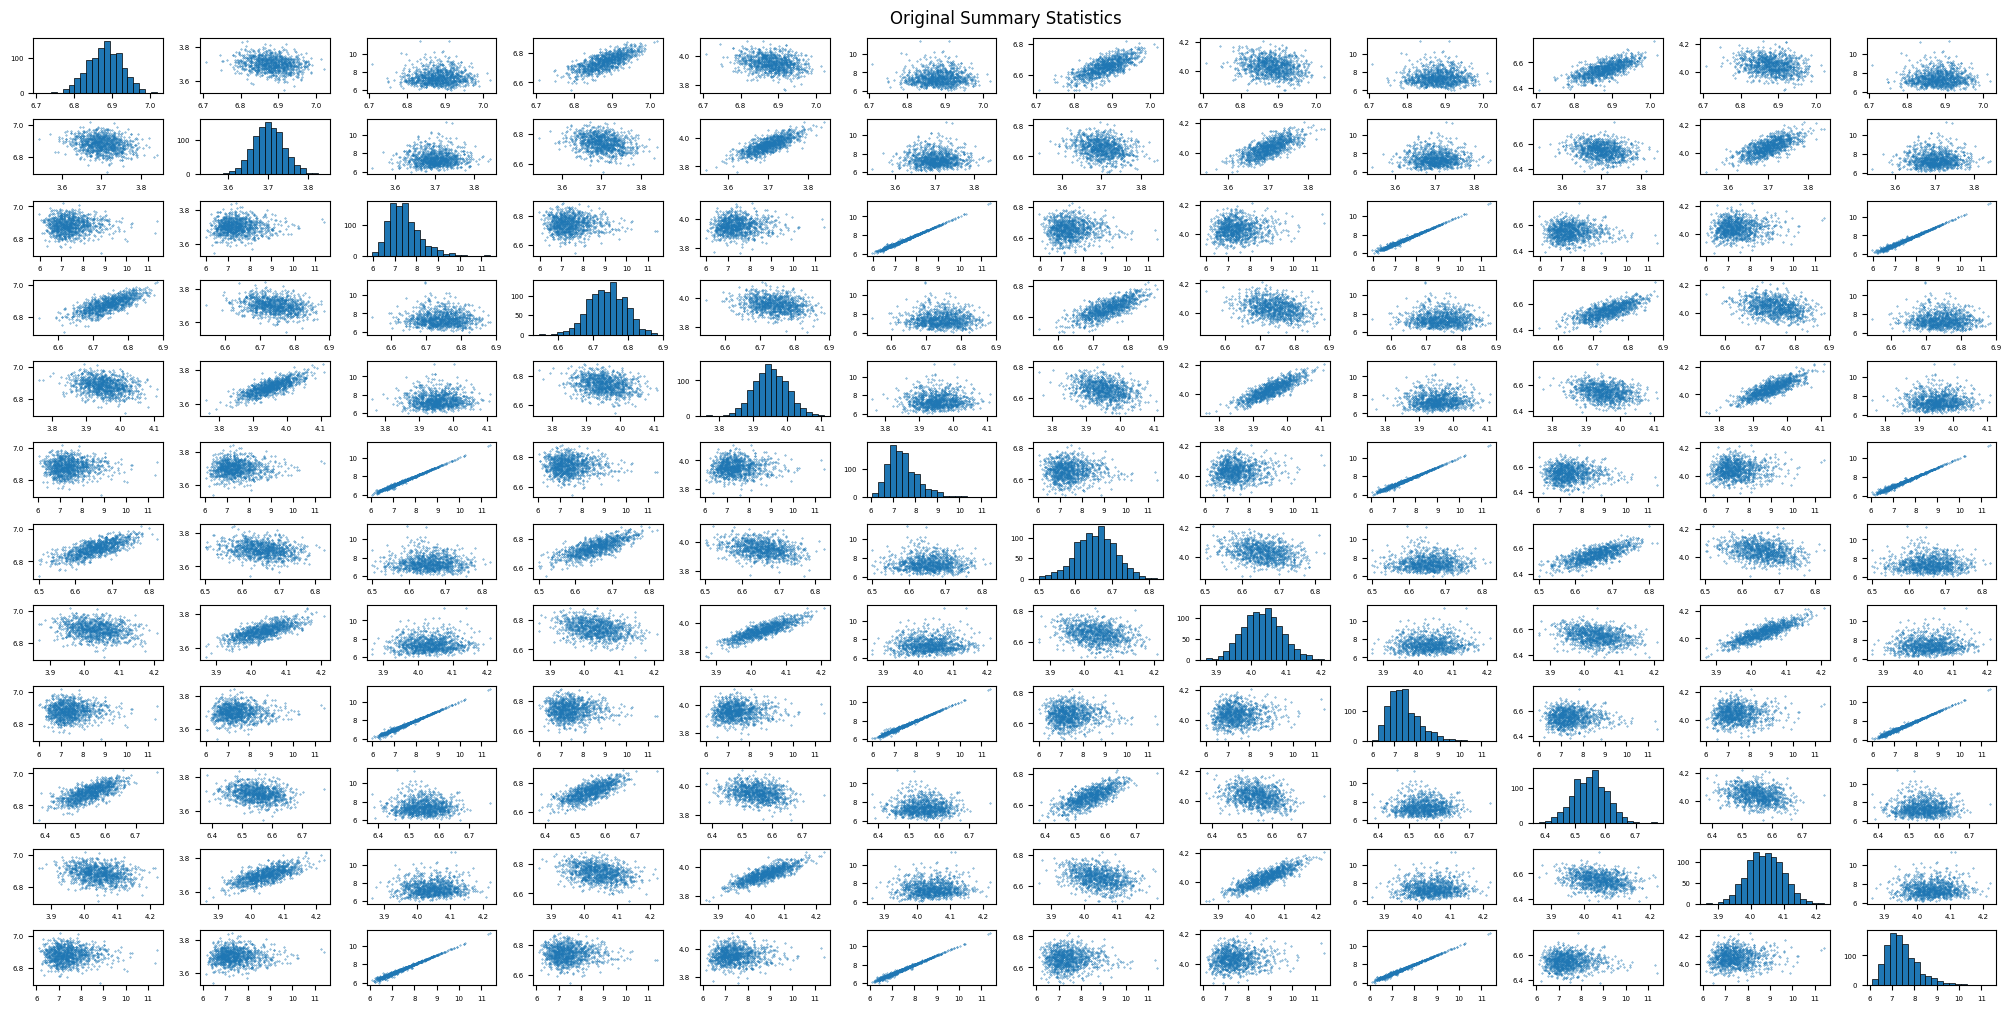

In [12]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(12, 12, figsize=(20,10), constrained_layout=True)

# For Sine Function
for x in range(12):
    for y in range(12):
        if x != y:
            axis[x, y].scatter(original_train_summary_statistics[:,x], original_train_summary_statistics[:,y], s = 0.1)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)
        else:
            axis[x, y].hist(original_train_summary_statistics[:,x], bins = 20, edgecolor='black', linewidth=0.5)
            axis[x, y].tick_params(axis='both', which='major', labelsize=5)

# Combine all the operations and display
figure.suptitle('Original Summary Statistics')
plt.show()

In [13]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_variance = np.cov(np.array(n_summary_statistics).T)
    return sample_mean, sample_variance

In [10]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = toad(theta[0], theta[1], theta[2],batch_size=n_datasets)
    n_summary_statistics = np.array([compute_summaries_stacked(datasets[:,:,i], lags)[0] for i in range(n_datasets)])
    sample_mean = np.mean(n_summary_statistics, axis = 0)
    sample_precision = 1/eps_precision * np.identity(actual_summary_statistics.shape[0])
    for i in range(n_datasets): ## It will have i ranging from 0 to N-1
        diff = n_summary_statistics[i] - sample_mean
        sample_precision = sample_precision - ((1 + diff.T @ sample_precision @ diff)**(-1)) * (sample_precision @ diff.reshape(-1, 1) @ diff.reshape(1, -1) @ sample_precision)
    sample_precision = sample_precision * n_datasets
    return sample_mean, sample_precision

In [14]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets)
    adjusted_sample_mean = sample_mean + np.diag(sqrtm(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [11]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_precision = summary_statistics(theta, n_samples, n_datasets)
    # Create a zero matrix with shape (num_latent, num_latent)
    precision_matrix = np.zeros((num_latent, num_latent))
    # Set the diagonal elements of the precision matrix using NumPy's indexing
    precision_matrix[np.diag_indices_from(precision_matrix)] = (np.diag(sample_precision))**(-1/2)
    adjusted_sample_mean = sample_mean + np.matmul(precision_matrix, Gamma)
    return adjusted_sample_mean, sample_precision

In [12]:
def prior(theta): 
    log_prior = np.sum(np.log(np.exp(theta) / (1 + np.exp(theta))**2))
    return log_prior

def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, n_samples, n_datasets):
    mean_adj_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, n_datasets)
    adjusted_sample_mean = mean_adj_ss[0]
    sample_precision = mean_adj_ss[1]

    # mean_u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    diff_mean_s = actual_summary_statistics - adjusted_sample_mean
    part1 = diff_mean_s.T @ sample_precision @ diff_mean_s
    mean_u_est_log_likelihood = 1/2 * np.linalg.slogdet(sample_precision)[1] - 1/2 * part1
    return mean_u_est_log_likelihood

def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    # part1 = (Gamma - mean_nuissance).T @ np.linalg.inv(variance_nuissance) @ (Gamma - mean_nuissance)
    # nuissance_mean_u_est_log_likelihood = -1/2 * np.log(np.linalg.det(variance_nuissance)) - part1
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [13]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_datasets = 200 # number of datasets
        self.num_coeffs = 3 # number of coeffs
        self.lambda_dim = self.num_coeffs + int((self.num_coeffs * (self.num_coeffs + 1)) / 2)
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_log_q(self, theta, mu, l):
        log_q = multivariate_normal.logpdf(theta, mean = mu, cov= np.linalg.inv(l @ l.T))
        return log_q

    def gradient_log_q(self, theta, mu, l): #indep theta
        gradient_log_q_mu = np.matmul(np.matmul(l, l.T), (theta - mu))
        diag_inv_l = np.zeros((num_coeffs, num_coeffs))
        np.fill_diagonal(diag_inv_l, np.diag(np.linalg.inv(l)))
        gradient_log_q_l = (diag_inv_l - np.reshape(theta - mu, (num_coeffs,1)) @ np.reshape(theta - mu, (1,num_coeffs)) @ l).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar 
        gradient_log_q = np.array([gradient_log_q_mu, gradient_log_q_l], dtype=object)
        return gradient_log_q

    def control_variates(self, Flat_grad_log_q, Flat_grad_lb):
        c = []
        stacked_gradient_lb = np.stack(Flat_grad_lb)
        stacked_gradient_log_q = np.stack(Flat_grad_log_q)
        for i in range(self.lambda_dim):
            sample_cov = np.cov((stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i]))
            c_i = sample_cov[0, 1] / sample_cov[1, 1]
            c.append(c_i)
        c_mu = np.array(c[0:self.num_coeffs])
        c_vech_l = np.array(c[self.num_coeffs:])
        return np.array([c_mu, c_vech_l], dtype = object)

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        #mu_0 = np.array([1.5, 0.5, 3, 0])
        # mu_0 = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = np.array([[ 3.94992238, -2.12969451,  0.47239626],
        #                 [-2.12969451, 21.85908684, -1.45228054],
        #                 [ 0.47239626, -1.45228054, 15.84326737]])
        l_0 = np.tril(np.identity(self.num_coeffs) * 10)
        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = np.linalg.inv(Sigma_0_inv)
        l_0_inv = np.linalg.inv(l_0)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[np.triu_indices(self.num_coeffs)]

        lambda_0 = np.array([mu_0, vech_l0], dtype = object)
        lambda_q = lambda_0
        # Initilize best lambda
        lambda_best = lambda_0
        # List of Lambda
        Lambda = [lambda_0]
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []
        for t in tqdm(range(stop)):
            if t == 0:        
                # Draw samples of theta from  variational q
                # List of gradients
                Gradient_lb_init = []
                lb_0 = []
                theta_0_samples = multivariate_normal.rvs(mean = mu_0, cov = Sigma_0, size = self.samples)
                for s in range(self.samples):
                    # True params have been reparam into epsilon
                    theta_tilde_0 = theta_0_samples[s]
                    alpha_0 = (2 * np.exp(theta_tilde_0[0]) + 1) / (1 + np.exp(theta_tilde_0[0]))
                    beta_0 = (100 * np.exp(theta_tilde_0[1]) + 0) / (1 + np.exp(theta_tilde_0[1]))
                    gamma_0 = (0.9 * np.exp(theta_tilde_0[2]) + 0) / (1 + np.exp(theta_tilde_0[2]))
                    theta_0 = np.array([alpha_0, beta_0, gamma_0])

                    ss_0 = summary_statistics(theta_0, n_samples, self.num_datasets)
                    sample_mean_0 = ss_0[0]
                    sample_precision_0 = ss_0[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_precision = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_precision, np.diag(sample_precision_0)**(-1/2))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_0 @ diag_precision)
                    diff_mean = actual_summary_statistics - sample_mean_0
                    mean_nuissance_p2 = diag_precision @ sample_precision_0 @ diff_mean
                    mean_nuissance_0 = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_0 = mean_nuissance_p1

                    # GENERATE GAMMA
                    Gamma = multivariate_normal.rvs(mean = mean_nuissance_0, cov = variance_nuissance_0)
                    # Gamma = Gamma[0]
                    adjusted_theta_0 = np.concatenate((theta_0, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_0, n_samples, self.num_datasets)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_0, variance_nuissance_0)

                    h_lambda_init = prior(theta_tilde_0) + prior(Gamma) + llh - self.fun_log_q(theta_tilde_0, mu_0, l_0) - llh_gamma

                    # Find gradient of LB
                    gradient_lb_init = self.gradient_log_q(theta_tilde_0, mu_0, l_0) * (h_lambda_init)
                    Gradient_lb_init.append(gradient_lb_init)
                    # Calculate control variates
                    flattened_gradient_log_q = np.concatenate((self.gradient_log_q(theta_tilde_0, mu_0, l_0)[0], self.gradient_log_q(theta_tilde_0, mu_0, l_0)[1]), axis = None)
                    Flattened_gradient_log_q.append(flattened_gradient_log_q)
                    flattened_gradient_lb = np.concatenate((gradient_lb_init[0], gradient_lb_init[1]), axis = None)
                    Flattened_gradient_lb.append(flattened_gradient_lb)
                    # Calculate lower bound
                    lb_0.append(h_lambda_init)
                # Calculate control variates using all samples
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_init = np.mean(Gradient_lb_init, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(self.g_init, axis = None)) > self.l_threshold:
                    self.g_init = self.l_threshold * self.g_init / np.linalg.norm(np.concatenate(self.g_init, axis = None))
                self.v_init = self.g_init ** 2
                # Calculate lower bound
                LB_all.append(np.mean(lb_0))
                print('LB', (np.mean(lb_0)))
                lambda_q = lambda_0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q[0]

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q[1])
                l_q = np.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q[i:self.num_coeffs,i] = vech_lq[:self.num_coeffs - i]
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  np.linalg.inv(Sigma_q_inv)
                l_q_inv =  np.linalg.inv(l_q)
                # List of gradients
                Gradient_lb = []
                lb_t = []
                theta_q_samples = multivariate_normal.rvs(mean = mu_q, cov = Sigma_q, size = self.samples)
                for s in range(self.samples):
                    theta_tilde_q = theta_q_samples[s]
                    # Calculate theta from mu, l (lambda)
                    alpha_q = (2 * np.exp(theta_tilde_q[0]) + 1) / (1 + np.exp(theta_tilde_q[0]))
                    beta_q = (100 * np.exp(theta_tilde_q[1]) + 0) / (1 + np.exp(theta_tilde_q[1]))
                    gamma_q = (0.9 * np.exp(theta_tilde_q[2]) + 0) / (1 + np.exp(theta_tilde_q[2]))
                    theta_q = np.array([alpha_q, beta_q, gamma_q])

                    ss_q = summary_statistics(theta_q, n_samples, self.num_datasets)
                    sample_mean_q = ss_q[0]
                    sample_precision_q = ss_q[1]

                    # Find mean and variance for p(gamma | theta, obs)
                
                    diag_precision = np.zeros((num_latent, num_latent))
                    np.fill_diagonal(diag_precision, np.diag(sample_precision_q)**(-1/2))
                    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_precision.T @ sample_precision_q @ diag_precision)
                    diff_mean = actual_summary_statistics - sample_mean_q
                    mean_nuissance_p2 = diag_precision @ sample_precision_q @ diff_mean
                    mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

                    variance_nuissance_q = mean_nuissance_p1

                    # GENERATE GAMMA
                    Gamma = multivariate_normal.rvs(mean = mean_nuissance_q, cov = variance_nuissance_q)
                    # Gamma = Gamma[0]
                    adjusted_theta_q = np.concatenate((theta_q, Gamma))

                    # Find gradient of LB
                    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, n_samples, self.num_datasets)
                    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

                    h_lambda = prior(theta_tilde_q) + prior(Gamma) + llh - self.fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma

                    # Find gradient of LB
                    gradient_lb = self.gradient_log_q(theta_tilde_q, mu_q, l_q) * (h_lambda - c)

                    Gradient_lb.append(gradient_lb)
                    # Calculate control variates
                    Flattened_gradient_log_q[s] = np.concatenate((self.gradient_log_q(theta_tilde_q, mu_q, l_q)[0], self.gradient_log_q(theta_tilde_q, mu_q, l_q)[1]), axis = None)
                    Flattened_gradient_lb[s] = np.concatenate((gradient_lb[0], gradient_lb[1]), axis = None)
                    # Calc lower bound estimate
                    lb_t.append(h_lambda)
                # Update control variates
                c = self.control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Calc gradient of h
                g_t = np.mean(Gradient_lb, axis = 0)
                # Gradient clipping
                if np.linalg.norm(np.concatenate(g_t, axis = None)) > self.l_threshold:
                    g_t = self.l_threshold * g_t / np.linalg.norm(np.concatenate(g_t, axis = None))
                v_t = g_t ** 2

                #---- Update lambda
                self.g_init = self.adaptive_lr_1 * self.g_init + (1 - self.adaptive_lr_1) * g_t
                self.v_init = self.adaptive_lr_2 * self.v_init + (1 - self.adaptive_lr_2) * v_t
                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q = lambda_q + update_t * self.g_init / (self.v_init ** 0.5)
                Lambda.append(lambda_q)
                # Calculate lower bound
                LB_all.append(np.mean(lb_t))

                if t < self.t_w:
                    print('LB', np.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = np.mean(LB_all[t - self.t_w + 1 : t])
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= max(LB_Smoothed):
                        patience = 0
                        lambda_best = lambda_q
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best

In [14]:
# Set hyperparameters
stop = 5000
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [10:57<912:23:01, 657.05s/it]

LB -15.571966657492926


  0%|          | 2/5000 [24:17<1029:00:59, 741.19s/it]

LB -15.699165915916264


  0%|          | 3/5000 [36:53<1038:28:20, 748.15s/it]

LB -15.685744326934811


  0%|          | 4/5000 [53:17<1167:39:24, 841.39s/it]

LB -15.463754674310962


  0%|          | 5/5000 [1:07:05<1160:42:26, 836.55s/it]

LB -15.736352093732096


  0%|          | 6/5000 [1:21:39<1178:01:23, 849.20s/it]

LB -15.879703845326729


  0%|          | 7/5000 [1:36:19<1191:55:19, 859.39s/it]

LB -15.775378601101671


  0%|          | 7/5000 [1:41:22<1205:12:17, 868.96s/it]


In [13]:
# Set hyperparameters
stop = 5000
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 50, 50)
LB_estimate, smoothed_LB_estimate, best_lambda = vb.vb_posterior(stop)

  0%|          | 1/5000 [08:21<696:10:09, 501.34s/it]

LB -165.30348754995492



  0%|          | 2/5000 [16:51<703:08:44, 506.47s/it]

LB -168.65514452642105



  0%|          | 3/5000 [25:13<700:14:49, 504.48s/it]

LB -160.08613018449574



  0%|          | 4/5000 [33:28<695:06:16, 500.88s/it]

LB -164.07382573790986



  0%|          | 5/5000 [41:53<696:48:03, 502.20s/it]

LB -162.18194615721396



  0%|          | 6/5000 [50:26<701:51:48, 505.95s/it]

LB -153.6025415424842



  0%|          | 7/5000 [58:52<701:38:32, 505.89s/it]

LB -156.99451935030578



  0%|          | 8/5000 [1:07:21<703:04:56, 507.03s/it]

LB -153.29632409641397



  0%|          | 9/5000 [1:15:45<701:26:57, 505.95s/it]

LB -152.0979641774737



  0%|          | 10/5000 [1:19:19<576:20:33, 415.80s/it]

LB -149.72778110874472



  0%|          | 11/5000 [1:22:10<472:38:41, 341.05s/it]

LB -145.77067697374184



  0%|          | 12/5000 [1:24:54<397:34:55, 286.95s/it]

LB -150.59281460346085



  0%|          | 13/5000 [1:27:30<342:42:37, 247.39s/it]

LB -146.0296698339692



  0%|          | 14/5000 [1:30:15<308:08:51, 222.49s/it]

LB -140.29233992070772



  0%|          | 15/5000 [1:32:55<282:11:18, 203.79s/it]

LB -143.90772881823287



  0%|          | 16/5000 [1:35:36<264:11:51, 190.83s/it]

LB -139.51503428049543



  0%|          | 17/5000 [1:38:17<251:31:56, 181.72s/it]

LB -137.30665742102116



  0%|          | 18/5000 [1:41:03<245:02:21, 177.07s/it]

LB -134.05530653403784



  0%|          | 19/5000 [1:43:47<239:34:35, 173.15s/it]

LB -133.87131926034897



  0%|          | 20/5000 [1:46:31<235:53:09, 170.52s/it]

LB -132.42112600444705



  0%|          | 21/5000 [1:49:21<235:34:25, 170.33s/it]

LB -125.434252469534



  0%|          | 22/5000 [1:52:24<240:48:14, 174.15s/it]

LB -122.70591350147859



  0%|          | 23/5000 [1:55:49<253:23:27, 183.28s/it]

LB -123.73185561190915



  0%|          | 24/5000 [1:59:17<263:37:47, 190.73s/it]

LB -122.29926269737545



  0%|          | 25/5000 [2:02:05<254:11:22, 183.94s/it]

LB -122.27665633389566



  1%|          | 26/5000 [2:04:35<240:12:13, 173.85s/it]

LB -123.45748562976249



  1%|          | 27/5000 [2:07:05<230:01:53, 166.52s/it]

LB -118.14355145701043



  1%|          | 28/5000 [2:09:28<220:18:15, 159.51s/it]

LB -116.54133941611293



  1%|          | 29/5000 [2:11:53<214:03:59, 155.03s/it]

LB -114.54302649264933



  1%|          | 30/5000 [2:14:17<209:44:10, 151.92s/it]

LB -114.66653770440455



  1%|          | 31/5000 [2:16:39<205:34:12, 148.93s/it]

LB -113.97299095813311



  1%|          | 32/5000 [2:19:03<203:25:09, 147.41s/it]

LB -108.5638100178587



  1%|          | 33/5000 [2:21:28<202:21:36, 146.67s/it]

LB -107.01293268565176



  1%|          | 34/5000 [2:23:53<201:27:07, 146.04s/it]

LB -105.59099968221393



  1%|          | 35/5000 [2:26:15<199:43:56, 144.82s/it]

LB -104.81826269644543



  1%|          | 36/5000 [2:28:42<200:42:19, 145.56s/it]

LB -97.79683195659779



  1%|          | 37/5000 [2:30:42<189:58:59, 137.81s/it]

LB -102.23413997661333



  1%|          | 38/5000 [2:32:40<182:04:18, 132.10s/it]

LB -97.72288200415329



  1%|          | 39/5000 [2:34:39<176:18:01, 127.93s/it]

LB -98.034273254511



  1%|          | 40/5000 [2:36:58<180:51:16, 131.27s/it]

LB -95.33120845117006



  1%|          | 41/5000 [2:39:16<183:55:26, 133.52s/it]

LB -95.37062938296232



  1%|          | 42/5000 [2:41:36<186:32:20, 135.45s/it]

LB -90.18829453884592



  1%|          | 43/5000 [2:43:58<189:07:14, 137.35s/it]

LB -89.77434768009225



  1%|          | 44/5000 [2:46:22<191:59:32, 139.46s/it]

LB -88.31167558875185



  1%|          | 45/5000 [2:48:42<192:01:53, 139.52s/it]

LB -88.4840944794509



  1%|          | 46/5000 [2:50:53<188:32:58, 137.02s/it]

LB -84.44714594752833



  1%|          | 47/5000 [2:53:14<189:51:16, 137.99s/it]

LB -81.07697950623977



  1%|          | 48/5000 [2:55:37<192:00:40, 139.59s/it]

LB -82.53207900730325



  1%|          | 49/5000 [2:57:55<191:30:13, 139.25s/it]

LB -83.38000911449667



  1%|          | 50/5000 [3:00:13<191:00:14, 138.91s/it]

LB -80.88679677095827



  1%|          | 51/5000 [3:02:31<190:12:48, 138.37s/it]

LB Smoothed -120.89406358257219



  1%|          | 52/5000 [3:05:00<194:40:57, 141.64s/it]

LB Smoothed -119.12999162628986



  1%|          | 53/5000 [3:07:22<194:46:12, 141.74s/it]

LB Smoothed -117.46306948472053



  1%|          | 54/5000 [3:09:49<197:02:08, 143.41s/it]

LB Smoothed -115.67032326063668



  1%|          | 55/5000 [3:12:17<198:42:44, 144.66s/it]

LB Smoothed -113.86888451785397



  1%|          | 56/5000 [3:14:36<196:35:53, 143.15s/it]

LB Smoothed -112.2550024122943



  1%|          | 57/5000 [3:16:35<186:33:48, 135.87s/it]

LB Smoothed -110.46105437782305



  1%|          | 58/5000 [3:18:43<183:19:52, 133.55s/it]

LB Smoothed -108.79051202745121



  1%|          | 59/5000 [3:20:56<182:54:16, 133.26s/it]

LB Smoothed -107.12859812869075



  1%|          | 60/5000 [3:23:14<184:44:20, 134.63s/it]

LB Smoothed -105.46663984734573



  1%|          | 61/5000 [3:25:16<179:37:54, 130.93s/it]

LB Smoothed -103.85437453122861



  1%|          | 62/5000 [3:27:23<177:47:51, 129.62s/it]

LB Smoothed -102.07045442341563



  1%|▏         | 63/5000 [3:29:29<176:14:27, 128.51s/it]

LB Smoothed -100.39319444763606



  1%|▏         | 64/5000 [3:33:34<224:30:36, 163.74s/it]

LB Smoothed -98.83012482419785



  1%|▏         | 65/5000 [3:37:51<262:28:38, 191.47s/it]

LB Smoothed -97.14741437421421



  1%|▏         | 66/5000 [3:41:42<278:47:24, 203.41s/it]

LB Smoothed -95.60208432343957



  1%|▏         | 67/5000 [3:45:39<292:37:04, 213.55s/it]

LB Smoothed -94.02909630044577



  1%|▏         | 68/5000 [3:49:21<296:01:02, 216.07s/it]

LB Smoothed -92.50818937152776



  1%|▏         | 69/5000 [3:55:06<348:58:47, 254.78s/it]

LB Smoothed -90.92542447851251



  1%|▏         | 70/5000 [4:00:12<369:46:42, 270.02s/it]

LB Smoothed -89.38035284600149



  1%|▏         | 71/5000 [4:04:14<358:28:17, 261.82s/it]

LB Smoothed -87.9190656226523



  1%|▏         | 72/5000 [4:08:12<348:27:42, 254.56s/it]

LB Smoothed -86.57465775337072



  1%|▏         | 73/5000 [4:12:10<341:30:50, 249.53s/it]

LB Smoothed -85.12446840490696



  1%|▏         | 74/5000 [4:16:06<335:46:37, 245.39s/it]

LB Smoothed -83.64787393181318



  2%|▏         | 75/5000 [4:21:30<368:02:12, 269.02s/it]

LB Smoothed -82.15079643127858



  2%|▏         | 76/5000 [4:27:19<400:58:02, 293.15s/it]

LB Smoothed -80.657566998461



  2%|▏         | 77/5000 [4:33:04<421:58:32, 308.57s/it]

LB Smoothed -79.21709694678613



  2%|▏         | 78/5000 [4:36:59<391:55:16, 286.66s/it]

LB Smoothed -77.80237141812147



  2%|▏         | 79/5000 [4:40:45<366:48:44, 268.34s/it]

LB Smoothed -76.46858145744129



  2%|▏         | 80/5000 [4:44:29<348:25:05, 254.94s/it]

LB Smoothed -75.13012939784453



  2%|▏         | 81/5000 [4:48:10<334:40:43, 244.94s/it]

LB Smoothed -73.70182353029263



  2%|▏         | 82/5000 [4:52:13<333:46:20, 244.32s/it]

LB Smoothed -72.42308103387269



  2%|▏         | 83/5000 [4:58:26<386:34:10, 283.03s/it]

LB Smoothed -71.15062779974815



  2%|▏         | 84/5000 [5:05:20<439:48:33, 322.07s/it]

LB Smoothed -69.88217254889473



  2%|▏         | 85/5000 [5:11:35<461:28:47, 338.01s/it]

LB Smoothed -68.65603834223548



  2%|▏         | 86/5000 [5:17:39<472:07:14, 345.88s/it]

LB Smoothed -67.5165643498995



  2%|▏         | 87/5000 [5:24:35<500:56:20, 367.06s/it]

LB Smoothed -66.2599108151158



  2%|▏         | 88/5000 [5:31:53<529:48:59, 388.30s/it]

LB Smoothed -65.11287711228314



  2%|▏         | 89/5000 [5:39:28<556:47:46, 408.16s/it]

LB Smoothed -63.96850400036286



  2%|▏         | 90/5000 [5:43:22<485:17:36, 355.82s/it]

LB Smoothed -62.844893777071945



  2%|▏         | 91/5000 [5:47:05<431:03:09, 316.11s/it]

LB Smoothed -61.69313079161442



  2%|▏         | 92/5000 [5:51:00<397:52:15, 291.84s/it]

LB Smoothed -60.65602945213727



  2%|▏         | 93/5000 [5:55:09<380:02:58, 278.82s/it]

LB Smoothed -59.59829696511264



  2%|▏         | 94/5000 [5:59:06<362:54:40, 266.30s/it]

LB Smoothed -58.547338901790674



  2%|▏         | 95/5000 [6:02:48<344:59:55, 253.21s/it]

LB Smoothed -57.483889867184125



  2%|▏         | 96/5000 [6:06:35<334:04:03, 245.24s/it]

LB Smoothed -56.479759316324454



  2%|▏         | 97/5000 [6:10:19<325:10:24, 238.76s/it]

LB Smoothed -55.49187980740717



  2%|▏         | 98/5000 [6:14:01<318:11:57, 233.68s/it]

LB Smoothed -54.53512455395094



  2%|▏         | 99/5000 [6:17:47<315:02:20, 231.41s/it]

LB Smoothed -53.54016796680538



  2%|▏         | 100/5000 [6:21:28<311:02:21, 228.52s/it]

LB Smoothed -52.563404017754934



  2%|▏         | 101/5000 [6:25:13<309:26:54, 227.40s/it]

LB Smoothed -51.5657078165851



  2%|▏         | 102/5000 [6:28:57<307:53:15, 226.30s/it]

LB Smoothed -50.64651333933368



  2%|▏         | 103/5000 [6:32:40<306:40:57, 225.46s/it]

LB Smoothed -49.738829704678686



  2%|▏         | 104/5000 [6:36:39<312:03:36, 229.46s/it]

LB Smoothed -48.881055164861024



  2%|▏         | 105/5000 [6:40:45<318:43:52, 234.41s/it]

LB Smoothed -47.983186583817016



  2%|▏         | 106/5000 [6:45:26<337:25:26, 248.21s/it]

LB Smoothed -47.18302883884754



  2%|▏         | 107/5000 [6:51:27<383:39:18, 282.27s/it]

LB Smoothed -46.329734335680975



  2%|▏         | 108/5000 [6:57:37<419:08:06, 308.44s/it]

LB Smoothed -45.48771780699812



  2%|▏         | 109/5000 [7:03:33<438:33:59, 322.80s/it]

LB Smoothed -44.66909930830072



  2%|▏         | 110/5000 [7:09:22<449:07:35, 330.65s/it]

LB Smoothed -43.868701007316645



  2%|▏         | 111/5000 [7:14:44<445:20:18, 327.92s/it]

LB Smoothed -43.138654328971775



  2%|▏         | 112/5000 [7:18:34<405:40:56, 298.78s/it]

LB Smoothed -42.34739322291046



  2%|▏         | 113/5000 [7:22:22<376:46:15, 277.55s/it]

LB Smoothed -41.55937886600733



  2%|▏         | 114/5000 [7:26:08<355:43:28, 262.10s/it]

LB Smoothed -40.80881737862156



  2%|▏         | 115/5000 [7:29:58<342:20:27, 252.29s/it]

LB Smoothed -40.014275657291805



  2%|▏         | 116/5000 [7:33:49<333:31:44, 245.84s/it]

LB Smoothed -39.305762045352566



  2%|▏         | 117/5000 [7:38:54<357:34:39, 263.62s/it]

LB Smoothed -38.57414362907967



  2%|▏         | 118/5000 [7:45:31<411:43:50, 303.61s/it]

LB Smoothed -37.91939827649971



  2%|▏         | 119/5000 [7:51:09<425:34:14, 313.88s/it]

LB Smoothed -37.25893544108096



  2%|▏         | 120/5000 [7:57:19<448:28:43, 330.84s/it]

LB Smoothed -36.60655214975475



  2%|▏         | 121/5000 [8:02:57<451:28:28, 333.12s/it]

LB Smoothed -35.89554785563148



  2%|▏         | 122/5000 [8:07:15<420:37:00, 310.42s/it]

LB Smoothed -35.26527190285014



  2%|▏         | 123/5000 [8:11:23<395:17:35, 291.79s/it]

LB Smoothed -34.69397941913266



  2%|▏         | 124/5000 [8:15:42<381:54:33, 281.97s/it]

LB Smoothed -34.14399511520444



  2%|▎         | 125/5000 [8:20:23<381:17:23, 281.57s/it]

LB Smoothed -33.55221952687897



  3%|▎         | 126/5000 [8:25:11<383:45:14, 283.45s/it]

LB Smoothed -33.00444991053718



  3%|▎         | 127/5000 [8:28:59<361:28:55, 267.05s/it]

LB Smoothed -32.46810123205006



  3%|▎         | 128/5000 [8:32:51<346:47:26, 256.25s/it]

LB Smoothed -31.90602785734154



  3%|▎         | 129/5000 [8:37:15<350:14:54, 258.86s/it]

LB Smoothed -31.296949907870395



  3%|▎         | 130/5000 [8:42:45<378:51:16, 280.06s/it]

LB Smoothed -30.780843053708075



  3%|▎         | 131/5000 [8:47:59<392:28:28, 290.18s/it]

LB Smoothed -30.265958114535987



  3%|▎         | 132/5000 [8:53:42<413:59:26, 306.16s/it]

LB Smoothed -29.758333991168882



  3%|▎         | 133/5000 [8:59:02<419:30:00, 310.29s/it]

LB Smoothed -29.28788518661081



  3%|▎         | 134/5000 [9:03:00<389:51:35, 288.43s/it]

LB Smoothed -28.74987046326256



  3%|▎         | 135/5000 [9:06:59<369:48:58, 273.66s/it]

LB Smoothed -28.28010329858503



  3%|▎         | 136/5000 [9:10:58<355:37:09, 263.21s/it]

LB Smoothed -27.824795678924364



  3%|▎         | 137/5000 [9:15:09<350:51:11, 259.73s/it]

LB Smoothed -27.340977969195052



  3%|▎         | 138/5000 [9:19:29<350:39:29, 259.64s/it]

LB Smoothed -26.855522775690993



  3%|▎         | 139/5000 [9:23:25<341:09:42, 252.66s/it]

LB Smoothed -26.38807809113941



  3%|▎         | 140/5000 [9:27:31<338:28:47, 250.73s/it]

LB Smoothed -25.947746773477036



  3%|▎         | 141/5000 [9:31:36<335:54:36, 248.87s/it]

LB Smoothed -25.48552630625415



  3%|▎         | 142/5000 [9:35:51<338:20:48, 250.73s/it]

LB Smoothed -25.060986315773437



  3%|▎         | 143/5000 [9:39:47<332:16:26, 246.28s/it]

LB Smoothed -24.639955620708314



  3%|▎         | 144/5000 [9:43:44<328:33:43, 243.58s/it]

LB Smoothed -24.235679193308425



  3%|▎         | 145/5000 [9:47:40<325:36:45, 241.44s/it]

LB Smoothed -23.847187918489837



  3%|▎         | 146/5000 [9:52:43<350:13:07, 259.74s/it]

LB Smoothed -23.477891528166875



  3%|▎         | 147/5000 [9:57:42<366:14:07, 271.68s/it]

LB Smoothed -23.103024502872618



  3%|▎         | 148/5000 [10:02:35<374:23:52, 277.79s/it]

LB Smoothed -22.72595738299248



  3%|▎         | 149/5000 [10:07:40<385:37:34, 286.18s/it]

LB Smoothed -22.39630750713216



  3%|▎         | 150/5000 [10:12:16<381:31:09, 283.19s/it]

LB Smoothed -22.05610167836201



  3%|▎         | 151/5000 [10:16:56<379:48:19, 281.98s/it]

LB Smoothed -21.70623742330155



  3%|▎         | 152/5000 [10:21:32<377:36:30, 280.40s/it]

LB Smoothed -21.375332436563337



  3%|▎         | 153/5000 [10:26:21<381:00:57, 282.99s/it]

LB Smoothed -21.02961678049949



  3%|▎         | 154/5000 [10:31:05<381:07:45, 283.13s/it]

LB Smoothed -20.708605490544915



  3%|▎         | 155/5000 [10:35:46<380:10:50, 282.49s/it]

LB Smoothed -20.406761095999983



  3%|▎         | 156/5000 [10:40:23<377:59:21, 280.92s/it]

LB Smoothed -20.10810739551272



  3%|▎         | 157/5000 [10:45:07<379:15:39, 281.92s/it]

LB Smoothed -19.784192087505073



  3%|▎         | 158/5000 [10:49:51<379:56:31, 282.48s/it]

LB Smoothed -19.50852953394547



  3%|▎         | 159/5000 [10:54:38<381:31:27, 283.72s/it]

LB Smoothed -19.215632307058115



  3%|▎         | 160/5000 [10:59:23<382:15:44, 284.33s/it]

LB Smoothed -18.9500327960217



  3%|▎         | 161/5000 [11:03:57<377:58:17, 281.19s/it]

LB Smoothed -18.698421688388464



  3%|▎         | 162/5000 [11:08:42<379:20:31, 282.27s/it]

LB Smoothed -18.468540079826017



  3%|▎         | 163/5000 [11:13:22<378:05:08, 281.40s/it]

LB Smoothed -18.229214184471246



  3%|▎         | 164/5000 [11:18:03<378:10:17, 281.52s/it]

LB Smoothed -17.99220851258412



  3%|▎         | 165/5000 [11:22:48<379:22:56, 282.48s/it]

LB Smoothed -17.719528336178872



  3%|▎         | 166/5000 [11:27:21<375:36:50, 279.73s/it]

LB Smoothed -17.50298101240034



  3%|▎         | 167/5000 [11:31:56<373:40:31, 278.34s/it]

LB Smoothed -17.26909464406278



  3%|▎         | 168/5000 [11:36:30<371:38:19, 276.88s/it]

LB Smoothed -17.02799046818014



  3%|▎         | 169/5000 [11:41:10<372:41:09, 277.72s/it]

LB Smoothed -16.824745772014825



  3%|▎         | 170/5000 [11:45:42<370:30:32, 276.16s/it]

LB Smoothed -16.631642585564144



  3%|▎         | 171/5000 [11:50:28<374:25:50, 279.14s/it]

LB Smoothed -16.42022232230771



  3%|▎         | 172/5000 [11:55:55<393:35:22, 293.48s/it]

LB Smoothed -16.1941916299865



  3%|▎         | 173/5000 [12:01:18<405:25:50, 302.37s/it]

LB Smoothed -15.972288054456527



  3%|▎         | 174/5000 [12:06:35<410:58:24, 306.57s/it]

LB Smoothed -15.751488235889257



  4%|▎         | 175/5000 [12:12:17<425:10:51, 317.23s/it]

LB Smoothed -15.548904685773156



  4%|▎         | 176/5000 [12:16:12<392:06:24, 292.62s/it]

LB Smoothed -15.343022230412592



  4%|▎         | 177/5000 [12:20:23<375:17:06, 280.12s/it]

LB Smoothed -15.12026749122876



  4%|▎         | 178/5000 [12:23:49<345:30:11, 257.95s/it]

LB Smoothed -14.935576006205293



  4%|▎         | 179/5000 [12:26:57<317:16:52, 236.92s/it]

LB Smoothed -14.749384007096237



  4%|▎         | 180/5000 [12:30:01<295:57:47, 221.05s/it]

LB Smoothed -14.539828388377071



  4%|▎         | 181/5000 [12:32:34<268:41:55, 200.73s/it]

LB Smoothed -14.337238391823497



  4%|▎         | 182/5000 [12:34:57<245:28:34, 183.42s/it]

LB Smoothed -14.13175241623086



  4%|▎         | 183/5000 [12:38:23<254:20:14, 190.08s/it]

LB Smoothed -13.996479437329041



  4%|▎         | 184/5000 [12:46:39<376:52:56, 281.72s/it]

LB Smoothed -13.814015157255803



  4%|▎         | 185/5000 [12:50:00<344:40:52, 257.71s/it]

LB Smoothed -13.660841571538217



  4%|▎         | 186/5000 [12:53:17<320:04:52, 239.36s/it]

LB Smoothed -13.498862194378729



  4%|▎         | 187/5000 [12:56:34<303:03:06, 226.67s/it]

LB Smoothed -13.352544933427861



  4%|▍         | 188/5000 [12:59:47<289:23:39, 216.50s/it]

LB Smoothed -13.203171716979892



  4%|▍         | 189/5000 [13:03:02<280:53:09, 210.18s/it]

LB Smoothed -13.066596476505964



  4%|▍         | 190/5000 [13:05:30<255:56:56, 191.56s/it]

LB Smoothed -12.93521014020512



  4%|▍         | 191/5000 [13:08:11<243:25:53, 182.23s/it]

LB Smoothed -12.779608426708972



  4%|▍         | 192/5000 [13:10:59<237:46:38, 178.04s/it]

LB Smoothed -12.650033047641577



  4%|▍         | 193/5000 [13:21:11<411:47:23, 308.39s/it]

LB Smoothed -12.524921824860778



  4%|▍         | 194/5000 [13:31:49<543:33:34, 407.16s/it]

LB Smoothed -12.40661680977658



  4%|▍         | 195/5000 [13:42:42<641:40:53, 480.76s/it]

LB Smoothed -12.320134154047643



  4%|▍         | 196/5000 [13:53:26<707:12:35, 529.97s/it]

LB Smoothed -12.18062977038129



  4%|▍         | 197/5000 [14:03:59<748:20:26, 560.90s/it]

LB Smoothed -12.057960976056046



  4%|▍         | 198/5000 [14:14:44<781:30:48, 585.89s/it]

LB Smoothed -11.915380449912325



  4%|▍         | 199/5000 [14:24:58<792:52:13, 594.53s/it]

LB Smoothed -11.778469963512569



  4%|▍         | 200/5000 [14:35:31<808:05:51, 606.07s/it]

LB Smoothed -11.644293095833326



  4%|▍         | 201/5000 [14:46:08<820:14:37, 615.31s/it]

LB Smoothed -11.52941341221984



  4%|▍         | 202/5000 [14:56:27<821:31:06, 616.40s/it]

LB Smoothed -11.4227891975657



  4%|▍         | 203/5000 [15:06:54<825:29:24, 619.50s/it]

LB Smoothed -11.316436471015544



  4%|▍         | 204/5000 [15:17:16<826:31:47, 620.41s/it]

LB Smoothed -11.209684234247389



  4%|▍         | 205/5000 [15:27:42<828:19:02, 621.89s/it]

LB Smoothed -11.124835814244875



  4%|▍         | 206/5000 [15:38:22<835:32:12, 627.44s/it]

LB Smoothed -11.051732180202075



  4%|▍         | 207/5000 [15:49:04<841:06:55, 631.76s/it]

LB Smoothed -10.966751622174462



  4%|▍         | 208/5000 [15:59:49<846:22:40, 635.84s/it]

LB Smoothed -10.912399750087426



  4%|▍         | 209/5000 [16:10:45<854:01:02, 641.72s/it]

LB Smoothed -10.832504109073913



  4%|▍         | 210/5000 [16:21:30<855:04:21, 642.64s/it]

LB Smoothed -10.773496227052394



  4%|▍         | 211/5000 [16:31:58<849:10:13, 638.34s/it]

LB Smoothed -10.695749667882842



  4%|▍         | 212/5000 [16:42:15<840:22:14, 631.86s/it]

LB Smoothed -10.631801743910547



  4%|▍         | 213/5000 [16:52:36<835:56:42, 628.66s/it]

LB Smoothed -10.561204262346049



  4%|▍         | 214/5000 [17:03:12<838:41:22, 630.86s/it]

LB Smoothed -10.519506917241765



  4%|▍         | 215/5000 [17:13:39<836:54:50, 629.65s/it]

LB Smoothed -10.449192769564146



  4%|▍         | 216/5000 [17:23:54<831:12:54, 625.50s/it]

LB Smoothed -10.392731065669748



  4%|▍         | 217/5000 [17:34:15<829:13:53, 624.13s/it]

LB Smoothed -10.339532932937045



  4%|▍         | 218/5000 [17:44:18<820:36:01, 617.77s/it]

LB Smoothed -10.281010538037522



  4%|▍         | 219/5000 [17:54:32<818:56:13, 616.64s/it]

LB Smoothed -10.233606717553075



  4%|▍         | 220/5000 [18:04:41<815:40:35, 614.32s/it]

LB Smoothed -10.209029000152787



  4%|▍         | 221/5000 [18:15:09<821:02:27, 618.49s/it]

LB Smoothed -10.181139120938429



  4%|▍         | 222/5000 [18:25:44<827:27:08, 623.45s/it]

LB Smoothed -10.148969635862237



  4%|▍         | 223/5000 [18:36:13<829:28:04, 625.10s/it]

LB Smoothed -10.128204597196317



  4%|▍         | 224/5000 [18:39:15<652:58:46, 492.20s/it]

LB Smoothed -10.116216483701821



  4%|▍         | 225/5000 [18:41:53<519:45:52, 391.86s/it]

LB Smoothed -10.101700006880998



  5%|▍         | 226/5000 [18:44:31<426:34:04, 321.67s/it]

LB Smoothed -10.077933298600897



  5%|▍         | 227/5000 [18:47:08<361:05:22, 272.35s/it]

LB Smoothed -10.050966641910291



  5%|▍         | 228/5000 [18:49:50<317:09:27, 239.26s/it]

LB Smoothed -10.055469147751598



  5%|▍         | 229/5000 [18:52:30<285:25:00, 215.36s/it]

LB Smoothed -10.04468931606536



  5%|▍         | 230/5000 [18:55:09<262:50:15, 198.37s/it]

LB Smoothed -10.032080315507399



  5%|▍         | 231/5000 [18:57:44<245:42:49, 185.48s/it]

LB Smoothed -10.005339046360426



  5%|▍         | 232/5000 [19:00:23<235:09:10, 177.55s/it]

LB Smoothed -9.98154510489312



  5%|▍         | 233/5000 [19:03:02<227:39:02, 171.92s/it]

LB Smoothed -9.97476878022042



  5%|▍         | 234/5000 [19:05:39<221:42:11, 167.46s/it]

LB Smoothed -9.938352512367345



  5%|▍         | 235/5000 [19:08:18<218:11:25, 164.84s/it]

LB Smoothed -9.947501949899694



  5%|▍         | 236/5000 [19:10:53<214:30:23, 162.10s/it]

LB Smoothed -9.923512967805983



  5%|▍         | 237/5000 [19:13:32<213:03:06, 161.03s/it]

LB Smoothed -9.921985260127219



  5%|▍         | 238/5000 [19:16:11<212:20:51, 160.53s/it]

LB Smoothed -9.909537675652025



  5%|▍         | 239/5000 [19:18:48<210:43:25, 159.34s/it]

LB Smoothed -9.89648019232772



  5%|▍         | 240/5000 [19:21:29<211:22:52, 159.87s/it]

LB Smoothed -9.896276513758169



  5%|▍         | 241/5000 [19:24:06<210:22:53, 159.15s/it]

LB Smoothed -9.905351942551365



  5%|▍         | 242/5000 [19:26:46<210:28:06, 159.24s/it]

LB Smoothed -9.871567792001745



  5%|▍         | 243/5000 [19:29:23<209:30:29, 158.55s/it]

LB Smoothed -9.849358181751358



  5%|▍         | 244/5000 [19:32:05<210:46:08, 159.54s/it]

LB Smoothed -9.842849972041284



  5%|▍         | 245/5000 [19:34:43<210:05:46, 159.06s/it]

LB Smoothed -9.835809473861008



  5%|▍         | 246/5000 [19:37:22<209:58:19, 159.00s/it]

LB Smoothed -9.828385594861029



  5%|▍         | 247/5000 [19:39:59<209:28:32, 158.66s/it]

LB Smoothed -9.822129755720082



  5%|▍         | 248/5000 [19:42:38<209:26:56, 158.67s/it]

LB Smoothed -9.824280943006357



  5%|▍         | 249/5000 [19:45:17<209:30:07, 158.75s/it]

LB Smoothed -9.829967925865736



  5%|▌         | 250/5000 [19:47:52<207:55:42, 157.59s/it]

LB Smoothed -9.83270929643701



  5%|▌         | 251/5000 [19:50:32<208:55:34, 158.38s/it]

LB Smoothed -9.851396576892565



  5%|▌         | 252/5000 [19:53:10<208:51:29, 158.36s/it]

LB Smoothed -9.859102748681408



  5%|▌         | 253/5000 [19:55:49<209:00:54, 158.51s/it]

LB Smoothed -9.855697652402872



  5%|▌         | 254/5000 [19:58:32<210:40:35, 159.81s/it]

LB Smoothed -9.83073635480988



  5%|▌         | 255/5000 [20:01:11<210:22:07, 159.61s/it]

LB Smoothed -9.827853084218104



  5%|▌         | 256/5000 [20:03:54<211:41:48, 160.65s/it]

LB Smoothed -9.812160453498558



  5%|▌         | 257/5000 [20:06:32<210:39:53, 159.90s/it]

LB Smoothed -9.784541190640722



  5%|▌         | 258/5000 [20:09:14<211:05:48, 160.26s/it]

LB Smoothed -9.76815340707673



  5%|▌         | 259/5000 [20:11:54<210:56:52, 160.18s/it]

LB Smoothed -9.748076612165935



  5%|▌         | 260/5000 [20:14:30<209:16:54, 158.95s/it]

LB Smoothed -9.760841024833608



  5%|▌         | 261/5000 [20:17:10<209:36:28, 159.23s/it]

LB Smoothed -9.748688034836142



  5%|▌         | 262/5000 [20:19:47<208:41:30, 158.57s/it]

LB Smoothed -9.726438771888008



  5%|▌         | 263/5000 [20:22:24<208:15:45, 158.27s/it]

LB Smoothed -9.70590694135025



  5%|▌         | 264/5000 [20:25:03<208:26:58, 158.45s/it]

LB Smoothed -9.682438076091655



  5%|▌         | 265/5000 [20:27:44<209:19:39, 159.15s/it]

LB Smoothed -9.671566400706737



  5%|▌         | 266/5000 [20:30:25<210:06:01, 159.77s/it]

LB Smoothed -9.66349980965428



  5%|▌         | 267/5000 [20:33:05<210:15:16, 159.92s/it]

LB Smoothed -9.657069634560871



  5%|▌         | 268/5000 [20:36:06<218:29:51, 166.23s/it]

LB Smoothed -9.627549359101982



  5%|▌         | 269/5000 [20:39:04<223:06:51, 169.78s/it]

LB Smoothed -9.626078746393041



  5%|▌         | 270/5000 [20:41:51<221:40:35, 168.72s/it]

LB Smoothed -9.617390900000567



  5%|▌         | 271/5000 [20:44:02<207:08:09, 157.68s/it]

LB Smoothed -9.606952532108519



  5%|▌         | 272/5000 [20:46:19<198:34:18, 151.20s/it]

LB Smoothed -9.594815621696467



  5%|▌         | 273/5000 [20:48:39<194:27:28, 148.10s/it]

LB Smoothed -9.563303787876068



  5%|▌         | 274/5000 [20:50:55<189:26:22, 144.30s/it]

LB Smoothed -9.533555986976765



  6%|▌         | 275/5000 [20:53:21<190:08:27, 144.87s/it]

LB Smoothed -9.514044226140333



  6%|▌         | 276/5000 [20:55:52<192:18:24, 146.55s/it]

LB Smoothed -9.528462646184375



  6%|▌         | 277/5000 [20:58:11<189:28:30, 144.42s/it]

LB Smoothed -9.515487985448372



  6%|▌         | 278/5000 [21:00:38<190:25:54, 145.18s/it]

LB Smoothed -9.481963363954312



  6%|▌         | 279/5000 [21:03:05<191:02:22, 145.68s/it]

LB Smoothed -9.460764745902319



  6%|▌         | 280/5000 [21:05:27<189:45:09, 144.73s/it]

LB Smoothed -9.467932857446273



  6%|▌         | 281/5000 [21:07:50<188:52:17, 144.09s/it]

LB Smoothed -9.443305763243043



  6%|▌         | 282/5000 [21:10:13<188:19:42, 143.70s/it]

LB Smoothed -9.43575320143296



  6%|▌         | 283/5000 [21:12:37<188:39:07, 143.98s/it]

LB Smoothed -9.422926565731224



  6%|▌         | 284/5000 [21:15:08<191:14:54, 145.99s/it]

LB Smoothed -9.40475527014117



  6%|▌         | 285/5000 [21:18:04<202:57:13, 154.96s/it]

LB Smoothed -9.379618687931199



  6%|▌         | 286/5000 [21:21:03<212:35:20, 162.35s/it]

LB Smoothed -9.368426827162821



  6%|▌         | 287/5000 [21:24:15<224:00:24, 171.11s/it]

LB Smoothed -9.362093963215134



  6%|▌         | 288/5000 [21:27:09<225:03:02, 171.94s/it]

LB Smoothed -9.359801073447331



  6%|▌         | 289/5000 [21:30:13<229:46:39, 175.59s/it]

LB Smoothed -9.346809458361223



  6%|▌         | 290/5000 [21:33:19<233:48:42, 178.71s/it]

LB Smoothed -9.33477299769039



  6%|▌         | 291/5000 [21:36:27<237:15:20, 181.38s/it]

LB Smoothed -9.33690388169458



  6%|▌         | 292/5000 [21:39:55<247:54:56, 189.57s/it]

LB Smoothed -9.318475494700547



  6%|▌         | 293/5000 [21:43:17<252:34:44, 193.18s/it]

LB Smoothed -9.30301498231212



  6%|▌         | 294/5000 [21:46:41<256:41:54, 196.37s/it]

LB Smoothed -9.28549499702605



  6%|▌         | 295/5000 [21:50:08<261:07:15, 199.79s/it]

LB Smoothed -9.30536091867719



  6%|▌         | 296/5000 [21:53:16<256:26:51, 196.26s/it]

LB Smoothed -9.288344750443468



  6%|▌         | 297/5000 [21:56:17<250:17:37, 191.59s/it]

LB Smoothed -9.263011885543815



  6%|▌         | 298/5000 [21:59:22<247:26:51, 189.45s/it]

LB Smoothed -9.22881083545424



  6%|▌         | 299/5000 [22:02:11<239:29:59, 183.41s/it]

LB Smoothed -9.217198312071577



  6%|▌         | 300/5000 [22:05:09<237:13:42, 181.71s/it]

LB Smoothed -9.177903635696644



  6%|▌         | 301/5000 [22:08:22<241:51:34, 185.29s/it]

LB Smoothed -9.166758957321063



  6%|▌         | 302/5000 [22:11:23<240:06:18, 183.99s/it]

LB Smoothed -9.145269864318578



  6%|▌         | 303/5000 [22:14:34<242:49:51, 186.12s/it]

LB Smoothed -9.129978975596444



  6%|▌         | 304/5000 [22:17:48<245:33:20, 188.25s/it]

LB Smoothed -9.102710557728903



  6%|▌         | 305/5000 [22:20:47<242:00:23, 185.56s/it]

LB Smoothed -9.099648479010535



  6%|▌         | 306/5000 [22:23:48<240:11:11, 184.21s/it]

LB Smoothed -9.089355692026476



  6%|▌         | 307/5000 [22:27:32<255:49:48, 196.25s/it]

LB Smoothed -9.084273967662112



  6%|▌         | 308/5000 [22:30:47<255:07:58, 195.75s/it]

LB Smoothed -9.078448012976917



  6%|▌         | 309/5000 [22:34:07<256:37:31, 196.94s/it]

LB Smoothed -9.062810053597813



  6%|▌         | 310/5000 [22:37:14<252:59:10, 194.19s/it]

LB Smoothed -9.056897442461185



  6%|▌         | 311/5000 [22:40:23<250:38:59, 192.44s/it]

LB Smoothed -9.095793624969229



  6%|▌         | 312/5000 [22:43:47<255:02:58, 195.86s/it]

LB Smoothed -9.083362562368729



  6%|▋         | 313/5000 [22:46:59<253:48:40, 194.95s/it]

LB Smoothed -9.085703526702645



  6%|▋         | 314/5000 [22:50:15<253:52:25, 195.04s/it]

LB Smoothed -9.063185253338682



  6%|▋         | 315/5000 [22:53:14<247:53:20, 190.48s/it]

LB Smoothed -9.061385110520808



  6%|▋         | 316/5000 [22:55:42<230:54:43, 177.47s/it]

LB Smoothed -9.069129093364442



  6%|▋         | 317/5000 [22:58:15<221:35:21, 170.34s/it]

LB Smoothed -9.075905196416166



  6%|▋         | 318/5000 [23:00:50<215:22:04, 165.60s/it]

LB Smoothed -9.048763802985777



  6%|▋         | 319/5000 [23:03:18<208:40:44, 160.49s/it]

LB Smoothed -9.056673806365513



  6%|▋         | 320/5000 [23:05:48<204:27:08, 157.27s/it]

LB Smoothed -9.046743057080853



  6%|▋         | 321/5000 [23:08:17<201:16:09, 154.86s/it]

LB Smoothed -9.058378768865339



  6%|▋         | 322/5000 [23:10:47<199:22:12, 153.43s/it]

LB Smoothed -9.039174615257414



  6%|▋         | 323/5000 [23:13:19<198:45:37, 152.99s/it]

LB Smoothed -9.036460442923655



  6%|▋         | 324/5000 [23:15:51<198:18:24, 152.67s/it]

LB Smoothed -9.045256706943418



  6%|▋         | 325/5000 [23:18:29<200:06:09, 154.09s/it]

LB Smoothed -9.037362196774453



  7%|▋         | 326/5000 [23:21:24<208:12:13, 160.36s/it]

LB Smoothed -9.035503885954626



  7%|▋         | 327/5000 [23:23:50<202:47:23, 156.23s/it]

LB Smoothed -9.069944899055598



  7%|▋         | 328/5000 [23:26:17<198:56:40, 153.30s/it]

LB Smoothed -9.0796671233896



  7%|▋         | 329/5000 [23:29:00<202:40:05, 156.20s/it]

LB Smoothed -9.071563326991765



  7%|▋         | 330/5000 [23:31:27<199:01:01, 153.42s/it]

LB Smoothed -9.06361457982943



  7%|▋         | 331/5000 [23:33:55<196:57:33, 151.86s/it]

LB Smoothed -9.044618942489647



  7%|▋         | 332/5000 [23:36:25<196:02:08, 151.18s/it]

LB Smoothed -9.060797902793132



  7%|▋         | 333/5000 [23:39:01<198:07:07, 152.82s/it]

LB Smoothed -9.035753528430318



  7%|▋         | 334/5000 [23:41:37<199:20:55, 153.81s/it]

LB Smoothed -9.0663785039762



  7%|▋         | 335/5000 [23:44:07<197:48:44, 152.65s/it]

LB Smoothed -9.048125405305523



  7%|▋         | 336/5000 [23:46:38<196:58:40, 152.04s/it]

LB Smoothed -9.04186142939904



  7%|▋         | 337/5000 [23:49:09<196:34:20, 151.76s/it]

LB Smoothed -9.038167175013884



  7%|▋         | 338/5000 [23:51:41<196:39:19, 151.86s/it]

LB Smoothed -9.06336524600503



  7%|▋         | 339/5000 [23:54:18<198:35:08, 153.38s/it]

LB Smoothed -9.057829456285297



  7%|▋         | 340/5000 [23:56:54<199:36:15, 154.20s/it]

LB Smoothed -9.072317844816228



  7%|▋         | 341/5000 [23:59:30<200:15:25, 154.74s/it]

LB Smoothed -9.083802687189618



  7%|▋         | 342/5000 [24:02:05<200:16:04, 154.78s/it]

LB Smoothed -9.088302222991704



  7%|▋         | 343/5000 [24:04:40<200:24:18, 154.92s/it]

LB Smoothed -9.083467666016015



  7%|▋         | 344/5000 [24:07:17<200:55:30, 155.35s/it]

LB Smoothed -9.050503154779802



  7%|▋         | 345/5000 [24:09:53<201:16:39, 155.66s/it]

LB Smoothed -9.053625384875472



  7%|▋         | 346/5000 [24:12:25<199:58:10, 154.68s/it]

LB Smoothed -9.06037858798494



  7%|▋         | 347/5000 [24:14:56<198:28:42, 153.56s/it]

LB Smoothed -9.081503830298598



  7%|▋         | 348/5000 [24:17:29<197:59:18, 153.22s/it]

LB Smoothed -9.082211550193309



  7%|▋         | 349/5000 [24:20:00<197:17:40, 152.71s/it]

LB Smoothed -9.095777927084681



  7%|▋         | 350/5000 [24:22:34<197:28:33, 152.88s/it]

LB Smoothed -9.08461292863314



  7%|▋         | 351/5000 [24:25:05<196:56:30, 152.50s/it]

LB Smoothed -9.102631438391397



  7%|▋         | 352/5000 [24:27:38<196:54:20, 152.51s/it]

LB Smoothed -9.100756881313773



  7%|▋         | 353/5000 [24:30:20<200:48:41, 155.57s/it]

LB Smoothed -9.118763176161657



  7%|▋         | 354/5000 [24:33:01<202:41:31, 157.06s/it]

LB Smoothed -9.12020987630804



  7%|▋         | 355/5000 [24:35:46<205:57:11, 159.62s/it]

LB Smoothed -9.146740811925671



  7%|▋         | 356/5000 [24:38:28<206:48:50, 160.32s/it]

LB Smoothed -9.137719372811064



  7%|▋         | 357/5000 [24:41:08<206:28:04, 160.09s/it]

LB Smoothed -9.147078034455307



  7%|▋         | 358/5000 [24:43:48<206:27:24, 160.11s/it]

LB Smoothed -9.121365943017707



  7%|▋         | 359/5000 [24:46:27<205:46:50, 159.62s/it]

LB Smoothed -9.110800960141743



  7%|▋         | 360/5000 [24:49:06<205:46:07, 159.65s/it]

LB Smoothed -9.09225317035771



  7%|▋         | 361/5000 [24:51:49<206:54:30, 160.57s/it]

LB Smoothed -9.120183771829222



  7%|▋         | 362/5000 [24:54:30<207:07:42, 160.77s/it]

LB Smoothed -9.13082650366727



  7%|▋         | 363/5000 [24:57:11<207:11:47, 160.86s/it]

LB Smoothed -9.157426519735921



  7%|▋         | 364/5000 [24:59:54<207:44:22, 161.32s/it]

LB Smoothed -9.152515220767594



  7%|▋         | 365/5000 [25:02:35<207:38:39, 161.28s/it]

LB Smoothed -9.165414826317479



  7%|▋         | 366/5000 [25:05:17<207:48:50, 161.44s/it]

LB Smoothed -9.17691274921839



  7%|▋         | 367/5000 [25:07:56<206:57:52, 160.82s/it]

LB Smoothed -9.1780260365075



  7%|▋         | 368/5000 [25:10:38<207:20:39, 161.15s/it]

LB Smoothed -9.171168795419348



  7%|▋         | 369/5000 [25:13:15<205:35:51, 159.83s/it]

LB Smoothed -9.17354318826684



  7%|▋         | 370/5000 [25:15:52<204:31:13, 159.02s/it]

LB Smoothed -9.182818224362471



  7%|▋         | 371/5000 [25:18:33<205:17:38, 159.66s/it]

LB Smoothed -9.2134645107842



  7%|▋         | 372/5000 [25:21:15<206:00:01, 160.24s/it]

LB Smoothed -9.232052294966966



  7%|▋         | 373/5000 [25:24:00<207:56:39, 161.79s/it]

LB Smoothed -9.242187259923929



  7%|▋         | 374/5000 [25:26:41<207:27:03, 161.44s/it]

LB Smoothed -9.229752362296999



  8%|▊         | 375/5000 [25:29:32<211:21:54, 164.52s/it]

LB Smoothed -9.237586079201932



  8%|▊         | 376/5000 [25:32:48<223:15:18, 173.81s/it]

LB Smoothed -9.22118658574874



  8%|▊         | 376/5000 [25:35:48<314:47:06, 245.07s/it]

LB Smoothed -9.248489128118827
Stop at 376


<AxesSubplot:title={'center':'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

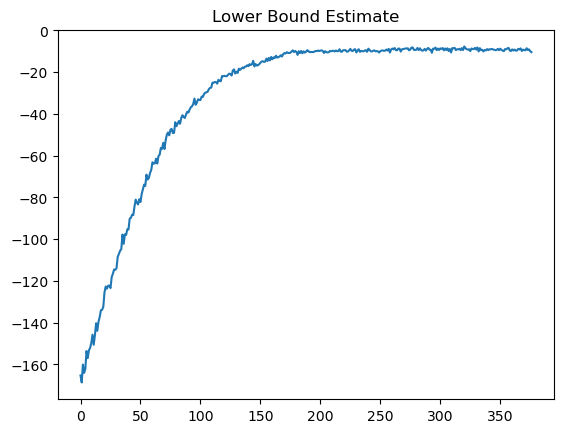

In [16]:
lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<AxesSubplot:>

<Figure size 640x480 with 0 Axes>

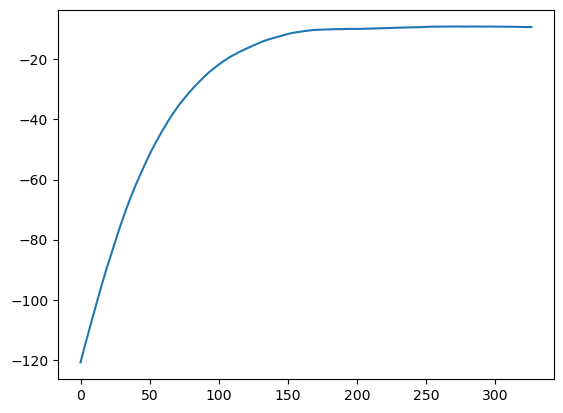

In [17]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(legend = False)

In [57]:
best_mu = best_lambda[0]
best_vech_l = list(best_lambda[1])
best_l = np.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l[i:num_coeffs,i] = best_vech_l[:num_coeffs - i]
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  np.linalg.inv(best_Sigma_inv)

best_theta_tilde = multivariate_normal.rvs(mean = best_mu, cov = best_Sigma, size = 1000)
best_alpha = (2 * np.exp(best_theta_tilde[:,0]) + 1) / (1 + np.exp(best_theta_tilde[:,0]))
best_beta = (100 * np.exp(best_theta_tilde[:,1]) + 0) / (1 + np.exp(best_theta_tilde[:,1]))
best_gamma = (0.9 * np.exp(best_theta_tilde[:,2]) + 0) / (1 + np.exp(best_theta_tilde[:,2]))
best_theta = np.array([best_alpha, best_beta, best_gamma])
posterior_mean_estimate = np.mean(best_theta, axis = 1)
posterior_mean_estimate

array([ 1.57745377, 32.21512732,  0.58784874])

Text(0.5, 1.0, 'Posterior density of alpha')

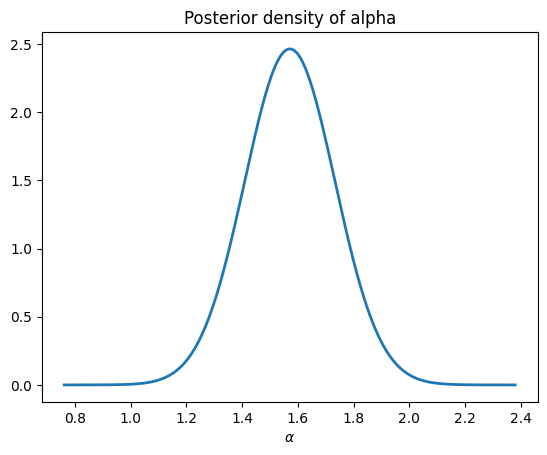

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_alpha)-5*np.std(best_alpha)), (np.mean(best_alpha)+5*np.std(best_alpha)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_alpha), np.std(best_alpha))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

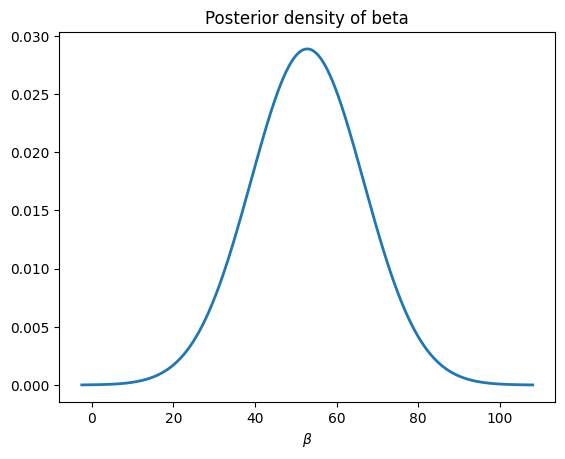

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_beta), np.std(best_beta))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

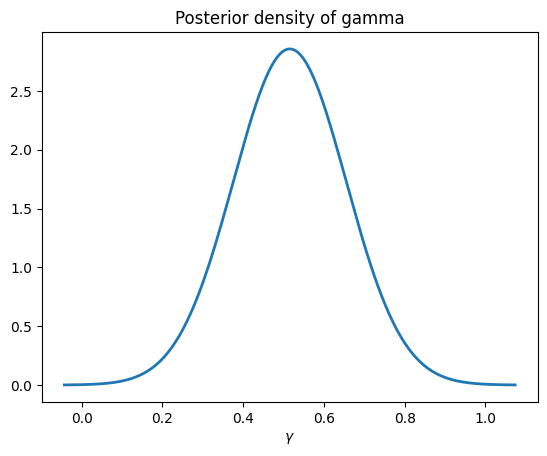

In [ ]:
plt.figure()
x_plot = np.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.001)
y_plot = ss.norm.pdf(x_plot, np.mean(best_gamma), np.std(best_gamma))
plt.plot(x_plot, y_plot, '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

## RUN MCMC

In [68]:
num_samples = 10000
num_burnin = 0.2 * num_samples

In [69]:
def sampler(samples):

    # ------------------- initialize MCMC

    theta_size = num_coeffs  # num of weights and bias

    pos_theta = np.ones((samples, theta_size))  # posterior of all weights and bias over all samples
    pos_theta_tilde = np.ones((samples, theta_size))

    theta_tilde = np.array([np.log((true_theta[0] - 1)/(2 - true_theta[0])),np.log((true_theta[1] - 0)/(100 - true_theta[1])),np.log((true_theta[2] - 0)/(0.9 - true_theta[2]))])

    alpha = (2 * np.exp(theta_tilde[0]) + 0) / (1 + np.exp(theta_tilde[0]))
    beta = (100 * np.exp(theta_tilde[1]) + 0) / (1 + np.exp(theta_tilde[1]))
    gamma = (0.9 * np.exp(theta_tilde[2]) + 0) / (1 + np.exp(theta_tilde[2]))

    theta = np.array([alpha, beta, gamma])

    ss = summary_statistics(theta, n_samples, num_datasets)
    sample_mean = ss[0]
    sample_variance = ss[1]
    # Nuissance mean and variance
    diag_var = np.zeros((num_latent, num_latent))
    np.fill_diagonal(diag_var, np.diag(sqrtm(sample_variance)))
    mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
    diff_mean = actual_summary_statistics - sample_mean
    mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
    mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

    variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

    # GENERATE GAMMA
    rng = np.random.default_rng()
    Gamma_init = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
    # Gamma = Gamma[0]
    adjusted_theta = np.concatenate((theta, Gamma_init))

    # Find gradient of LB
    llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta, n_samples, num_datasets)
    llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma_init, mean_nuissance, variance_nuissance)

    # --------------------- 

    prior_current = prior(theta_tilde)  # takes care of the gradients

    likelihood_current = llh

    naccept = 0

    for i in tqdm(range(samples - 1)):
        # theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * np.identity(theta_size)))
        if i < 1000:
#             theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * np.identity(theta_size)))
            theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))
        else:
            if i % 500 == 0:
                Sign = np.cov(pos_theta_tilde[0:i, :].T)
            u_proposal = np.random.uniform(0, 1)
            if u_proposal < 0.5:
            # if u_proposal < 0.05:
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * np.identity(theta_size)))
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((0.1**2.5/theta_size) * best_Sigma))  
            else:
                # theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (2.38**2/theta_size) * Sign)
#                 theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = (1.1**2.5/theta_size) * Sign)
                theta_proposal_tilde = multivariate_normal.rvs(mean = theta_tilde, cov = ((1.1**2.5/theta_size) * best_Sigma))

        alpha_prop = (2 * np.exp(theta_proposal_tilde[0]) + 0) / (1 + np.exp(theta_proposal_tilde[0]))
        beta_prop = (100 * np.exp(theta_proposal_tilde[1]) + 0) / (1 + np.exp(theta_proposal_tilde[1]))
        gamma_prop = (0.9 * np.exp(theta_proposal_tilde[2]) + 0) / (1 + np.exp(theta_proposal_tilde[2]))

        theta_proposal = np.array([alpha_prop, beta_prop, gamma_prop])

        ss = summary_statistics(theta_proposal, n_samples, num_datasets)
        sample_mean = ss[0]
        sample_variance = ss[1]
        # Find mean and variance for p(gamma | theta, obs)

        diag_var = np.zeros((num_latent, num_latent))
        np.fill_diagonal(diag_var, np.diag(sqrtm(sample_variance)))
        mean_nuissance_p1 = my_inv(np.identity(num_latent) / sigma_latent + diag_var.T @ my_inv(sample_variance) @ diag_var)
        diff_mean = actual_summary_statistics - sample_mean
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance) @ diff_mean
        mean_nuissance = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance = mean_nuissance_p1  #+ (np.eye(mean_nuissance_p1.shape[0]) * 5 * 1e-7)

        # GENERATE GAMMA
        rng = np.random.default_rng()
        Gamma = rng.multivariate_normal(mean = mean_nuissance, cov = variance_nuissance)
        # Gamma = Gamma[0]
        adjusted_theta_proposal = np.concatenate((theta_proposal, Gamma))


        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_proposal, n_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance)       
        # --------------------- 

        prior_proposal = prior(theta_proposal_tilde)  # takes care of the gradients
        likelihood_proposal = llh

        diff_prior = prior_proposal - prior_current

        diff_likelihood = likelihood_proposal - likelihood_current

        try:
            mh_prob = min(1, math.exp(diff_likelihood+diff_prior))

        except OverflowError as e:
            mh_prob = 1


        u = np.random.uniform(0, 1)

        if u < mh_prob:
            # Update position 
            naccept += 1
            likelihood_current = likelihood_proposal
            prior_current = prior_proposal
            theta_tilde = theta_proposal_tilde
            theta = theta_proposal
            pos_theta_tilde[i + 1,] = theta_proposal_tilde	
            pos_theta[i + 1,] = theta_proposal
            print(i, pos_theta[i + 1,])
            print(i, naccept / (samples * 1.0) * 100, '% was accepted')

        else:
            pos_theta_tilde[i + 1,] = pos_theta_tilde[i,]
            pos_theta[i + 1,] = pos_theta[i,]

    print(naccept, ' num accepted')
    print(naccept / (samples * 1.0) * 100, '% was accepted')
    accept_ratio = naccept / (samples * 1.0) * 100

    return (pos_theta, pos_theta_tilde, accept_ratio)

In [70]:
pos_w, pos_w_tilde, accept_ratio = sampler(num_samples)

  0%|          | 6/9999 [00:03<1:38:50,  1.69it/s]

5 [ 1.39897773 35.03331942  0.60068914]
5 0.01 % was accepted


  0%|          | 13/9999 [00:08<1:46:53,  1.56it/s]

12 [ 1.40138697 35.13253338  0.6019801 ]
12 0.02 % was accepted


  0%|          | 18/9999 [00:13<3:01:59,  1.09s/it]

17 [ 1.40110364 35.09262561  0.60225029]
17 0.03 % was accepted


  0%|          | 23/9999 [00:18<2:35:32,  1.07it/s]

22 [ 1.40082173 35.22771473  0.60191627]
22 0.04 % was accepted


  0%|          | 25/9999 [00:20<2:45:10,  1.01it/s]

24 [ 1.40199864 35.29898886  0.60274643]
24 0.05 % was accepted


  1%|          | 50/9999 [00:54<3:22:13,  1.22s/it]

49 [ 1.40386606 35.3250772   0.60283669]
49 0.06 % was accepted


  1%|          | 107/9999 [02:09<4:07:27,  1.50s/it]

106 [ 1.40193668 35.42142374  0.60382259]
106 0.06999999999999999 % was accepted


 15%|█▍        | 1468/9999 [1:29:12<4:10:32,  1.76s/it] 

1467 [ 1.40223511 35.42948318  0.60356714]
1467 0.08 % was accepted


 15%|█▍        | 1478/9999 [1:29:28<3:50:21,  1.62s/it]

1477 [ 1.41190462 33.28837848  0.60070644]
1477 0.09 % was accepted


 15%|█▍        | 1490/9999 [1:29:51<4:48:34,  2.03s/it]

1489 [ 1.4148897  32.20952357  0.59190466]
1489 0.1 % was accepted


 15%|█▍        | 1492/9999 [1:29:54<4:42:19,  1.99s/it]

1491 [ 1.41485682 32.2281052   0.59270049]
1491 0.11 % was accepted


 15%|█▍        | 1494/9999 [1:29:58<4:10:35,  1.77s/it]

1493 [ 1.41543103 32.23532041  0.59295306]
1493 0.12 % was accepted


 15%|█▌        | 1500/9999 [1:30:10<4:38:41,  1.97s/it]

1499 [ 1.4128479  32.22146771  0.59317588]
1499 0.13 % was accepted



 15%|█▌        | 1501/9999 [1:30:11<4:26:32,  1.88s/it]

1500 [ 1.4115441  32.31697219  0.59328481]
1500 0.13999999999999999 % was accepted


 15%|█▌        | 1511/9999 [1:30:34<5:30:44,  2.34s/it]

1510 [ 1.40970924 32.25519943  0.59295484]
1510 0.15 % was accepted


 15%|█▌        | 1519/9999 [1:30:57<5:56:16,  2.52s/it]

1518 [ 1.41303097 32.19222519  0.58933672]
1518 0.16 % was accepted


 15%|█▌        | 1531/9999 [1:31:25<6:03:26,  2.58s/it]

1530 [ 1.38795711 31.95820734  0.58570341]
1530 0.16999999999999998 % was accepted



 15%|█▌        | 1532/9999 [1:31:27<5:39:59,  2.41s/it]

1531 [ 1.35223542 30.18778554  0.59922656]
1531 0.18 % was accepted


 16%|█▌        | 1596/9999 [1:33:44<6:00:07,  2.57s/it]

1595 [ 1.36886655 30.60524441  0.63137082]
1595 0.19 % was accepted


 17%|█▋        | 1688/9999 [1:37:21<5:00:04,  2.17s/it]

1687 [ 1.36713314 30.50076866  0.63065001]
1687 0.2 % was accepted


 17%|█▋        | 1704/9999 [1:37:54<5:52:42,  2.55s/it]

1703 [ 1.36627063 30.39883959  0.62900886]
1703 0.21 % was accepted


 17%|█▋        | 1711/9999 [1:38:10<5:36:31,  2.44s/it]

1710 [ 1.36377445 30.36600431  0.62820136]
1710 0.22 % was accepted


 17%|█▋        | 1747/9999 [1:39:33<4:35:31,  2.00s/it]

1746 [ 1.3684949  30.25463362  0.62837853]
1746 0.22999999999999998 % was accepted


 18%|█▊        | 1763/9999 [1:40:15<5:58:00,  2.61s/it]

1762 [ 1.36835732 30.29860048  0.62825697]
1762 0.24 % was accepted


 18%|█▊        | 1771/9999 [1:40:34<6:09:13,  2.69s/it]

1770 [ 1.36861104 30.31040064  0.62814036]
1770 0.25 % was accepted


 18%|█▊        | 1808/9999 [1:41:50<4:33:37,  2.00s/it]

1807 [ 1.37036446 30.31652229  0.62771168]
1807 0.26 % was accepted


 19%|█▊        | 1855/9999 [1:43:31<4:56:58,  2.19s/it]

1854 [ 1.36967327 30.26614091  0.62827874]
1854 0.27 % was accepted


 19%|█▉        | 1900/9999 [1:45:32<5:22:23,  2.39s/it]

1899 [ 1.37022079 30.25644015  0.62951688]
1899 0.27999999999999997 % was accepted


 19%|█▉        | 1911/9999 [1:46:00<5:30:27,  2.45s/it]

1910 [ 1.35853561 31.98432271  0.62756544]
1910 0.29 % was accepted


 19%|█▉        | 1927/9999 [1:46:44<6:17:39,  2.81s/it]

1926 [ 1.34874014 31.61203058  0.61573111]
1926 0.3 % was accepted


 19%|█▉        | 1940/9999 [1:47:23<6:57:58,  3.11s/it]

1939 [ 1.34898216 31.66731108  0.61553958]
1939 0.31 % was accepted


 20%|█▉        | 1952/9999 [1:47:54<5:03:26,  2.26s/it]

1951 [ 1.36119592 31.74676458  0.63133695]
1951 0.32 % was accepted


 20%|██        | 2007/9999 [1:50:53<8:44:41,  3.94s/it]

2006 [ 1.39958452 32.26626364  0.60344147]
2006 0.33 % was accepted


 20%|██        | 2010/9999 [1:51:02<7:14:30,  3.26s/it]

2009 [ 1.43067704 31.93090117  0.5979033 ]
2009 0.33999999999999997 % was accepted


 20%|██        | 2015/9999 [1:51:19<7:28:07,  3.37s/it]

2014 [ 1.42838833 31.61039738  0.5674325 ]
2014 0.35000000000000003 % was accepted


 20%|██        | 2023/9999 [1:51:46<7:30:45,  3.39s/it]

2022 [ 1.41885235 30.89919473  0.56111836]
2022 0.36 % was accepted


 20%|██        | 2025/9999 [1:51:52<7:08:29,  3.22s/it]

2024 [ 1.41823829 30.97818892  0.56164598]
2024 0.37 % was accepted


 20%|██        | 2030/9999 [1:52:04<5:25:45,  2.45s/it]

2029 [ 1.4198303  29.50491575  0.57489054]
2029 0.38 % was accepted


 20%|██        | 2043/9999 [1:52:44<6:55:26,  3.13s/it]

2042 [ 1.41816365 29.52924296  0.57542484]
2042 0.38999999999999996 % was accepted


 21%|██        | 2050/9999 [1:53:10<7:37:43,  3.46s/it]

2049 [ 1.41861214 29.65178069  0.57438912]
2049 0.4 % was accepted


 21%|██        | 2081/9999 [1:55:00<6:59:02,  3.18s/it]

2080 [ 1.41124799 29.43659838  0.53405336]
2080 0.41000000000000003 % was accepted


 21%|██▏       | 2128/9999 [1:57:52<9:03:24,  4.14s/it] 

2127 [ 1.41381534 29.53240189  0.53404682]
2127 0.42 % was accepted


 21%|██▏       | 2130/9999 [1:58:00<9:18:14,  4.26s/it]

2129 [ 1.42188418 28.56966091  0.54068775]
2129 0.43 % was accepted


 22%|██▏       | 2170/9999 [2:00:43<11:44:22,  5.40s/it]

2169 [ 1.4217762  28.60358703  0.5404421 ]
2169 0.44 % was accepted


 22%|██▏       | 2227/9999 [2:05:20<7:31:46,  3.49s/it] 

2226 [ 1.42482545 28.4879995   0.53994325]
2226 0.44999999999999996 % was accepted


 23%|██▎       | 2313/9999 [2:10:55<6:21:22,  2.98s/it] 

2312 [ 1.44777652 30.21038568  0.55995537]
2312 0.45999999999999996 % was accepted


 24%|██▍       | 2393/9999 [2:14:41<6:49:54,  3.23s/it]

2392 [ 1.42983281 31.51057716  0.55885348]
2392 0.47000000000000003 % was accepted



 24%|██▍       | 2394/9999 [2:14:44<6:49:22,  3.23s/it]

2393 [ 1.43192579 31.37303739  0.55937468]
2393 0.48 % was accepted


 24%|██▍       | 2402/9999 [2:15:08<6:29:26,  3.08s/it]

2401 [ 1.43241697 31.31009086  0.55995298]
2401 0.49 % was accepted


 24%|██▍       | 2444/9999 [2:17:14<6:20:43,  3.02s/it]

2443 [ 1.48617758 29.5182135   0.56184262]
2443 0.5 % was accepted


 25%|██▍       | 2454/9999 [2:17:41<5:25:14,  2.59s/it]

2453 [ 1.46808741 29.91186842  0.58405002]
2453 0.51 % was accepted


 28%|██▊       | 2772/9999 [2:49:37<18:03:03,  8.99s/it]

2771 [ 1.46831558 29.85525586  0.58372483]
2771 0.52 % was accepted


 28%|██▊       | 2788/9999 [2:51:03<11:13:06,  5.60s/it]

2787 [ 1.46837772 29.80523428  0.58276311]
2787 0.53 % was accepted


 28%|██▊       | 2806/9999 [2:53:00<13:45:06,  6.88s/it]

2805 [ 1.48921992 30.62646448  0.59457145]
2805 0.54 % was accepted


 28%|██▊       | 2810/9999 [2:53:25<11:55:24,  5.97s/it]

2809 [ 1.48823762 30.58721436  0.59428373]
2809 0.5499999999999999 % was accepted


 28%|██▊       | 2816/9999 [2:53:59<11:50:38,  5.94s/it]

2815 [ 1.49018618 30.57981408  0.59378146]
2815 0.5599999999999999 % was accepted


 28%|██▊       | 2819/9999 [2:54:16<11:00:35,  5.52s/it]

2818 [ 1.48601527 28.92203728  0.59154973]
2818 0.5700000000000001 % was accepted


 29%|██▊       | 2855/9999 [2:58:12<11:18:08,  5.70s/it]

2854 [ 1.52123085 28.51230598  0.57081647]
2854 0.58 % was accepted


 29%|██▉       | 2876/9999 [3:00:09<11:05:54,  5.61s/it]

2875 [ 1.51910515 28.58102243  0.57072387]
2875 0.59 % was accepted


 29%|██▉       | 2902/9999 [3:02:34<7:21:01,  3.73s/it] 

2901 [ 1.51998542 28.53562692  0.57156749]
2901 0.6 % was accepted


 29%|██▉       | 2912/9999 [3:03:16<8:35:34,  4.36s/it]

2911 [ 1.51912994 28.48967329  0.57170308]
2911 0.61 % was accepted


 29%|██▉       | 2919/9999 [3:03:54<10:09:49,  5.17s/it]

2918 [ 1.53044637 31.79385262  0.56392134]
2918 0.62 % was accepted



 29%|██▉       | 2920/9999 [3:03:59<10:04:27,  5.12s/it]

2919 [ 1.55440981 30.57672783  0.5637303 ]
2919 0.63 % was accepted


 29%|██▉       | 2942/9999 [3:05:28<6:29:08,  3.31s/it] 

2941 [ 1.58529278 31.16005363  0.55708957]
2941 0.64 % was accepted


 30%|██▉       | 2950/9999 [3:05:54<6:43:10,  3.43s/it]

2949 [ 1.58361513 31.23752339  0.55606703]
2949 0.65 % was accepted


 30%|██▉       | 2972/9999 [3:07:02<6:07:39,  3.14s/it]

2971 [ 1.57084688 30.42662013  0.5642772 ]
2971 0.66 % was accepted


 30%|███       | 3016/9999 [3:09:23<5:17:18,  2.73s/it]

3015 [ 1.56701697 31.13591492  0.56554189]
3015 0.67 % was accepted


 30%|███       | 3021/9999 [3:09:38<5:31:10,  2.85s/it]

3020 [ 1.57624537 30.01573234  0.60055578]
3020 0.6799999999999999 % was accepted



 30%|███       | 3022/9999 [3:09:40<5:18:30,  2.74s/it]

3021 [ 1.62133412 31.40126383  0.59416359]
3021 0.69 % was accepted



 30%|███       | 3023/9999 [3:09:43<5:12:39,  2.69s/it]

3022 [ 1.62063599 31.31894064  0.59460395]
3022 0.7000000000000001 % was accepted


 30%|███       | 3026/9999 [3:09:54<6:25:41,  3.32s/it]

3025 [ 1.61849849 31.31830439  0.59414654]
3025 0.7100000000000001 % was accepted


 30%|███       | 3029/9999 [3:10:02<5:45:42,  2.98s/it]

3028 [ 1.62483599 31.35340057  0.59393753]
3028 0.72 % was accepted


 30%|███       | 3038/9999 [3:10:29<5:32:50,  2.87s/it]

3037 [ 1.62475286 31.3341981   0.59487457]
3037 0.73 % was accepted


 31%|███       | 3059/9999 [3:11:25<5:21:26,  2.78s/it]

3058 [ 1.62356483 31.24586718  0.59396108]
3058 0.74 % was accepted


 32%|███▏      | 3152/9999 [3:16:22<7:34:41,  3.98s/it] 

3151 [ 1.57267376 31.64534833  0.5887958 ]
3151 0.75 % was accepted


 32%|███▏      | 3158/9999 [3:16:46<7:29:36,  3.94s/it]

3157 [ 1.60097989 31.10642283  0.58351137]
3157 0.76 % was accepted


 32%|███▏      | 3186/9999 [3:18:23<7:34:34,  4.00s/it]

3185 [ 1.59447294 32.59415945  0.58498404]
3185 0.77 % was accepted


 32%|███▏      | 3236/9999 [3:21:29<6:17:14,  3.35s/it]

3235 [ 1.59501608 32.43495671  0.58477954]
3235 0.7799999999999999 % was accepted


 32%|███▏      | 3243/9999 [3:22:03<9:10:35,  4.89s/it]

3242 [ 1.57168648 32.91782877  0.58674629]
3242 0.79 % was accepted


 33%|███▎      | 3268/9999 [3:24:07<8:49:15,  4.72s/it] 

3267 [ 1.5720291  32.95410347  0.58604239]
3267 0.8 % was accepted


 33%|███▎      | 3282/9999 [3:25:07<8:33:46,  4.59s/it]

3281 [ 1.57358201 33.55354277  0.5666558 ]
3281 0.8099999999999999 % was accepted


 33%|███▎      | 3284/9999 [3:25:15<7:54:08,  4.24s/it]

3283 [ 1.57349322 33.72185454  0.56731982]
3283 0.8200000000000001 % was accepted


 33%|███▎      | 3297/9999 [3:26:15<9:02:51,  4.86s/it]

3296 [ 1.57310191 33.76647106  0.56765025]
3296 0.83 % was accepted


 33%|███▎      | 3299/9999 [3:26:22<7:42:19,  4.14s/it]

3298 [ 1.57226565 34.20432006  0.58124061]
3298 0.84 % was accepted



 33%|███▎      | 3300/9999 [3:26:25<7:25:47,  3.99s/it]

3299 [ 1.58425378 34.27023021  0.57678345]
3299 0.8500000000000001 % was accepted



 33%|███▎      | 3301/9999 [3:26:28<6:30:07,  3.49s/it]

3300 [ 1.58370433 34.25417556  0.57671387]
3300 0.86 % was accepted



 33%|███▎      | 3302/9999 [3:26:31<6:10:25,  3.32s/it]

3301 [ 1.55493612 35.84146444  0.59125442]
3301 0.8699999999999999 % was accepted


 33%|███▎      | 3306/9999 [3:26:43<5:51:26,  3.15s/it]

3305 [ 1.57792547 34.24921892  0.59300347]
3305 0.88 % was accepted



 33%|███▎      | 3307/9999 [3:26:46<5:51:39,  3.15s/it]

3306 [ 1.57786908 35.4934106   0.60733111]
3306 0.89 % was accepted


 33%|███▎      | 3309/9999 [3:26:53<6:04:47,  3.27s/it]

3308 [ 1.57829563 35.78596018  0.61340708]
3308 0.8999999999999999 % was accepted


 33%|███▎      | 3311/9999 [3:27:00<6:28:42,  3.49s/it]

3310 [ 1.57723448 35.7273585   0.61201455]
3310 0.91 % was accepted


 33%|███▎      | 3315/9999 [3:27:16<7:02:34,  3.79s/it]

3314 [ 1.57732831 35.69164564  0.61248564]
3314 0.9199999999999999 % was accepted



 33%|███▎      | 3316/9999 [3:27:19<6:45:58,  3.64s/it]

3315 [ 1.61132558 35.35632517  0.619276  ]
3315 0.9299999999999999 % was accepted


 33%|███▎      | 3335/9999 [3:28:36<7:27:51,  4.03s/it]

3334 [ 1.62889987 32.7601824   0.61052909]
3334 0.9400000000000001 % was accepted


 33%|███▎      | 3340/9999 [3:28:57<7:32:56,  4.08s/it]

3339 [ 1.62860375 32.70021937  0.61054077]
3339 0.95 % was accepted


 33%|███▎      | 3343/9999 [3:29:08<7:13:48,  3.91s/it]

3342 [ 1.60460854 32.10188886  0.6028394 ]
3342 0.96 % was accepted


 34%|███▍      | 3381/9999 [3:31:38<8:10:41,  4.45s/it]

3380 [ 1.60442419 31.947204    0.60207927]
3380 0.97 % was accepted


 34%|███▍      | 3392/9999 [3:32:16<5:41:42,  3.10s/it]

3391 [ 1.6049286  31.96555566  0.60169831]
3391 0.98 % was accepted


 34%|███▍      | 3403/9999 [3:32:59<8:11:35,  4.47s/it]

3402 [ 1.60477001 31.94158382  0.60243471]
3402 0.9900000000000001 % was accepted


 35%|███▍      | 3473/9999 [3:38:36<9:08:57,  5.05s/it] 

3472 [ 1.60481906 31.93340186  0.60191187]
3472 1.0 % was accepted


 35%|███▍      | 3499/9999 [3:40:37<8:17:35,  4.59s/it]

3498 [ 1.61073219 31.64687868  0.60324021]
3498 1.01 % was accepted


 35%|███▌      | 3543/9999 [3:43:58<7:27:33,  4.16s/it] 

3542 [ 1.61122144 31.67897166  0.6031689 ]
3542 1.02 % was accepted


 36%|███▌      | 3552/9999 [3:44:30<6:43:39,  3.76s/it]

3551 [ 1.62743931 30.18101943  0.60812438]
3551 1.03 % was accepted


 36%|███▌      | 3556/9999 [3:44:43<5:35:37,  3.13s/it]

3555 [ 1.62721173 30.40264713  0.60832535]
3555 1.04 % was accepted


 36%|███▌      | 3585/9999 [3:46:19<5:24:15,  3.03s/it]

3584 [ 1.62641783 30.34017887  0.60908273]
3584 1.05 % was accepted


 36%|███▌      | 3607/9999 [3:47:25<4:33:38,  2.57s/it]

3606 [ 1.62521364 30.22966954  0.61039697]
3606 1.06 % was accepted


 36%|███▌      | 3615/9999 [3:47:49<5:03:46,  2.85s/it]

3614 [ 1.61016847 29.83255111  0.6040762 ]
3614 1.0699999999999998 % was accepted



 36%|███▌      | 3616/9999 [3:47:51<4:43:06,  2.66s/it]

3615 [ 1.61110189 29.84137102  0.60461981]
3615 1.08 % was accepted


 36%|███▌      | 3618/9999 [3:47:57<4:44:02,  2.67s/it]

3617 [ 1.61235879 29.82582899  0.60403173]
3617 1.09 % was accepted


 36%|███▋      | 3646/9999 [3:49:31<6:32:46,  3.71s/it]

3645 [ 1.61169947 29.83594972  0.60385002]
3645 1.0999999999999999 % was accepted


 37%|███▋      | 3659/9999 [3:50:16<6:30:30,  3.70s/it]

3658 [ 1.61352339 29.92635668  0.60369999]
3658 1.11 % was accepted


 37%|███▋      | 3666/9999 [3:50:40<7:24:42,  4.21s/it]

3665 [ 1.61313572 29.83251836  0.60418256]
3665 1.1199999999999999 % was accepted



 37%|███▋      | 3667/9999 [3:50:48<9:15:33,  5.26s/it]

3666 [ 1.61444651 29.83303898  0.6045574 ]
3666 1.13 % was accepted


 37%|███▋      | 3670/9999 [3:50:59<7:30:49,  4.27s/it]

3669 [ 1.61532661 29.84928579  0.60278068]
3669 1.1400000000000001 % was accepted


 37%|███▋      | 3679/9999 [3:51:27<6:33:27,  3.74s/it]

3678 [ 1.61561883 29.84759303  0.60266345]
3678 1.15 % was accepted


 37%|███▋      | 3694/9999 [3:52:28<5:45:39,  3.29s/it] 

3693 [ 1.61762655 29.92422363  0.60222551]
3693 1.16 % was accepted


 37%|███▋      | 3697/9999 [3:52:44<8:00:43,  4.58s/it]

3696 [ 1.6181313  29.78815237  0.60268382]
3696 1.17 % was accepted


 37%|███▋      | 3703/9999 [3:53:08<6:30:40,  3.72s/it]

3702 [ 1.61816902 29.77746373  0.60270837]
3702 1.18 % was accepted


 37%|███▋      | 3736/9999 [3:55:09<7:12:19,  4.14s/it]

3735 [ 1.62559214 31.61769217  0.59624169]
3735 1.1900000000000002 % was accepted


 38%|███▊      | 3754/9999 [3:56:20<5:22:27,  3.10s/it]

3753 [ 1.6255298  31.52343642  0.59604985]
3753 1.2 % was accepted



 38%|███▊      | 3755/9999 [3:56:23<5:05:26,  2.94s/it]

3754 [ 1.6259092  31.49402855  0.59596265]
3754 1.21 % was accepted


 38%|███▊      | 3760/9999 [3:56:37<4:46:45,  2.76s/it]

3759 [ 1.62502177 31.45141131  0.59516114]
3759 1.22 % was accepted


 38%|███▊      | 3765/9999 [3:56:53<5:29:36,  3.17s/it]

3764 [ 1.62615979 31.57013047  0.59518139]
3764 1.23 % was accepted


 38%|███▊      | 3768/9999 [3:56:58<4:06:52,  2.38s/it]

3767 [ 1.62747824 32.79829417  0.59786193]
3767 1.24 % was accepted


 38%|███▊      | 3774/9999 [3:57:14<4:18:18,  2.49s/it]

3773 [ 1.62729702 32.73803424  0.59860922]
3773 1.25 % was accepted


 38%|███▊      | 3779/9999 [3:57:27<4:19:22,  2.50s/it]

3778 [ 1.62579612 32.77424145  0.59743394]
3778 1.26 % was accepted


 38%|███▊      | 3796/9999 [3:58:17<5:48:14,  3.37s/it]

3795 [ 1.6264709  32.69455761  0.59733398]
3795 1.27 % was accepted


 38%|███▊      | 3798/9999 [3:58:22<5:10:43,  3.01s/it]

3797 [ 1.63257784 33.10397606  0.59592715]
3797 1.28 % was accepted


 38%|███▊      | 3823/9999 [3:59:46<6:37:23,  3.86s/it]

3822 [ 1.63190929 33.0998314   0.59590957]
3822 1.29 % was accepted


 38%|███▊      | 3832/9999 [4:00:20<5:49:13,  3.40s/it]

3831 [ 1.63393232 33.60356618  0.6020445 ]
3831 1.3 % was accepted


 39%|███▉      | 3886/9999 [4:03:17<6:12:38,  3.66s/it]

3885 [ 1.63443332 33.51086688  0.60144313]
3885 1.31 % was accepted


 39%|███▉      | 3889/9999 [4:03:25<5:07:48,  3.02s/it]

3888 [ 1.63363012 33.41685707  0.6016226 ]
3888 1.32 % was accepted



 39%|███▉      | 3890/9999 [4:03:28<5:24:11,  3.18s/it]

3889 [ 1.63211    33.40818685  0.60134495]
3889 1.3299999999999998 % was accepted


 39%|███▉      | 3900/9999 [4:03:56<4:44:42,  2.80s/it]

3899 [ 1.62973483 33.3977604   0.60091765]
3899 1.34 % was accepted


 39%|███▉      | 3943/9999 [4:05:42<5:32:36,  3.30s/it]

3942 [ 1.62899132 33.45626881  0.60146087]
3942 1.35 % was accepted


 39%|███▉      | 3945/9999 [4:05:50<6:13:16,  3.70s/it]

3944 [ 1.63036242 33.51770033  0.60154274]
3944 1.3599999999999999 % was accepted


 40%|███▉      | 3953/9999 [4:06:21<6:09:36,  3.67s/it]

3952 [ 1.62570422 32.54645908  0.58588105]
3952 1.37 % was accepted


 40%|███▉      | 3955/9999 [4:06:26<5:08:02,  3.06s/it]

3954 [ 1.6243955  32.60860932  0.58586488]
3954 1.38 % was accepted


 40%|███▉      | 3958/9999 [4:06:33<4:16:21,  2.55s/it]

3957 [ 1.65048563 31.48808909  0.58063485]
3957 1.39 % was accepted


 40%|███▉      | 3961/9999 [4:06:40<4:08:12,  2.47s/it]

3960 [ 1.64819367 30.91881106  0.59634575]
3960 1.4000000000000001 % was accepted


 40%|███▉      | 3967/9999 [4:06:54<3:59:33,  2.38s/it]

3966 [ 1.64834943 30.97429175  0.59519042]
3966 1.41 % was accepted


 40%|███▉      | 3979/9999 [4:07:23<4:19:25,  2.59s/it]

3978 [ 1.64927683 30.93154769  0.59589504]
3978 1.4200000000000002 % was accepted


 40%|███▉      | 3994/9999 [4:08:08<4:20:12,  2.60s/it]

3993 [ 1.65792382 32.66463931  0.56590252]
3993 1.43 % was accepted



 40%|███▉      | 3995/9999 [4:08:11<4:14:21,  2.54s/it]

3994 [ 1.65127621 31.98064966  0.57134448]
3994 1.44 % was accepted


 40%|████      | 4002/9999 [4:08:30<4:55:41,  2.96s/it]

4001 [ 1.65375603 32.07706733  0.57152154]
4001 1.4500000000000002 % was accepted



 40%|████      | 4003/9999 [4:08:35<5:50:07,  3.50s/it]

4002 [ 1.65480225 32.07845345  0.5716474 ]
4002 1.46 % was accepted


 40%|████      | 4005/9999 [4:08:41<5:29:09,  3.29s/it]

4004 [ 1.66591027 30.65044626  0.55952992]
4004 1.47 % was accepted


 40%|████      | 4010/9999 [4:08:56<5:31:59,  3.33s/it]

4009 [ 1.62363203 30.57263299  0.56626918]
4009 1.48 % was accepted



 40%|████      | 4011/9999 [4:08:59<5:20:50,  3.21s/it]

4010 [ 1.62235273 30.53700499  0.56562942]
4010 1.49 % was accepted


 41%|████      | 4094/9999 [4:13:16<5:30:18,  3.36s/it]

4093 [ 1.62314409 30.5683554   0.56540271]
4093 1.5 % was accepted


 41%|████▏     | 4142/9999 [4:15:19<3:36:35,  2.22s/it]

4141 [ 1.623392   30.56617902  0.56534332]
4141 1.51 % was accepted


 42%|████▏     | 4179/9999 [4:17:14<5:26:28,  3.37s/it]

4178 [ 1.64005382 31.28012561  0.573932  ]
4178 1.52 % was accepted


 42%|████▏     | 4181/9999 [4:17:21<5:30:55,  3.41s/it]

4180 [ 1.63797365 31.32926355  0.61130673]
4180 1.53 % was accepted


 42%|████▏     | 4203/9999 [4:18:26<5:08:38,  3.19s/it]

4202 [ 1.63626684 31.34695752  0.60976172]
4202 1.54 % was accepted


 42%|████▏     | 4206/9999 [4:18:34<4:55:30,  3.06s/it]

4205 [ 1.63672941 31.40065901  0.60859461]
4205 1.55 % was accepted


 42%|████▏     | 4228/9999 [4:19:45<5:17:26,  3.30s/it]

4227 [ 1.63049532 30.58265666  0.58435788]
4227 1.5599999999999998 % was accepted


 42%|████▏     | 4234/9999 [4:20:08<5:56:34,  3.71s/it]

4233 [ 1.65995673 31.39623937  0.5913584 ]
4233 1.5699999999999998 % was accepted


 42%|████▏     | 4239/9999 [4:20:23<5:02:04,  3.15s/it]

4238 [ 1.65940455 31.32822141  0.59129907]
4238 1.58 % was accepted



 42%|████▏     | 4240/9999 [4:20:25<4:44:26,  2.96s/it]

4239 [ 1.69641573 29.37465415  0.58924267]
4239 1.59 % was accepted


 42%|████▏     | 4244/9999 [4:20:37<4:40:38,  2.93s/it]

4243 [ 1.71338804 30.1716653   0.58436415]
4243 1.6 % was accepted


 42%|████▏     | 4246/9999 [4:20:44<4:56:34,  3.09s/it]

4245 [ 1.6851507  29.52652178  0.60848526]
4245 1.6099999999999999 % was accepted


 43%|████▎     | 4250/9999 [4:20:59<5:52:14,  3.68s/it]

4249 [ 1.64443973 30.21213628  0.60236203]
4249 1.6199999999999999 % was accepted


 43%|████▎     | 4271/9999 [4:22:08<4:41:06,  2.94s/it]

4270 [ 1.6549821  33.42833529  0.60895245]
4270 1.63 % was accepted


 43%|████▎     | 4284/9999 [4:22:41<3:59:42,  2.52s/it]

4283 [ 1.65538805 34.24541254  0.60570447]
4283 1.6400000000000001 % was accepted


 43%|████▎     | 4317/9999 [4:24:12<4:30:21,  2.85s/it]

4316 [ 1.68939158 33.77496634  0.61090858]
4316 1.6500000000000001 % was accepted


 43%|████▎     | 4341/9999 [4:25:29<4:36:27,  2.93s/it]

4340 [ 1.68986665 33.86058444  0.61082247]
4340 1.66 % was accepted


 44%|████▎     | 4353/9999 [4:25:59<3:55:38,  2.50s/it]

4352 [ 1.69105417 33.87153966  0.61180529]
4352 1.67 % was accepted


 44%|████▎     | 4356/9999 [4:26:07<4:20:29,  2.77s/it]

4355 [ 1.68918198 32.60301167  0.60889794]
4355 1.68 % was accepted


 44%|████▎     | 4374/9999 [4:26:48<3:27:08,  2.21s/it]

4373 [ 1.6895512  32.61070087  0.60784396]
4373 1.69 % was accepted


 44%|████▍     | 4377/9999 [4:26:56<3:55:36,  2.51s/it]

4376 [ 1.69006142 32.6955459   0.60800745]
4376 1.7000000000000002 % was accepted


 44%|████▍     | 4390/9999 [4:27:30<4:32:20,  2.91s/it]

4389 [ 1.69156497 31.45262569  0.58894491]
4389 1.71 % was accepted


 44%|████▍     | 4393/9999 [4:27:45<6:34:30,  4.22s/it]

4392 [ 1.69077341 31.47814869  0.58995619]
4392 1.72 % was accepted


 44%|████▍     | 4396/9999 [4:27:57<6:08:58,  3.95s/it]

4395 [ 1.69001879 31.53040288  0.58931768]
4395 1.73 % was accepted


 44%|████▍     | 4401/9999 [4:28:16<5:44:57,  3.70s/it]

4400 [ 1.70072438 31.11690507  0.5853229 ]
4400 1.7399999999999998 % was accepted


 44%|████▍     | 4407/9999 [4:28:34<5:02:41,  3.25s/it]

4406 [ 1.70845933 31.83066342  0.58879696]
4406 1.7500000000000002 % was accepted


 44%|████▍     | 4413/9999 [4:28:55<5:02:25,  3.25s/it]

4412 [ 1.70823527 31.74072347  0.58774164]
4412 1.76 % was accepted


 44%|████▍     | 4416/9999 [4:29:03<4:12:12,  2.71s/it]

4415 [ 1.70722316 31.78064046  0.58745024]
4415 1.77 % was accepted


 44%|████▍     | 4420/9999 [4:29:11<3:30:21,  2.26s/it]

4419 [ 1.70626163 31.77010679  0.587878  ]
4419 1.78 % was accepted


 45%|████▍     | 4452/9999 [4:30:30<3:55:54,  2.55s/it]

4451 [ 1.7067208  31.74392572  0.58904525]
4451 1.79 % was accepted


 45%|████▍     | 4454/9999 [4:30:34<3:46:29,  2.45s/it]

4453 [ 1.69978667 32.10237642  0.58887082]
4453 1.7999999999999998 % was accepted


 45%|████▍     | 4459/9999 [4:30:53<5:36:23,  3.64s/it]

4458 [ 1.70040654 32.10346739  0.58815622]
4458 1.81 % was accepted


 45%|████▍     | 4471/9999 [4:31:31<4:51:49,  3.17s/it]

4470 [ 1.70164777 32.09111851  0.58709104]
4470 1.82 % was accepted


 45%|████▍     | 4474/9999 [4:31:40<4:33:24,  2.97s/it]

4473 [ 1.72258747 32.93185144  0.6043549 ]
4473 1.83 % was accepted


 45%|████▍     | 4483/9999 [4:32:07<4:22:57,  2.86s/it]

4482 [ 1.70962668 31.62298234  0.60065855]
4482 1.8399999999999999 % was accepted


 45%|████▍     | 4485/9999 [4:32:14<4:46:59,  3.12s/it]

4484 [ 1.71009543 31.60990331  0.601286  ]
4484 1.8499999999999999 % was accepted


 45%|████▍     | 4490/9999 [4:32:34<5:21:25,  3.50s/it]

4489 [ 1.70395012 30.79240067  0.61633523]
4489 1.8599999999999999 % was accepted


 45%|████▍     | 4493/9999 [4:32:42<4:39:06,  3.04s/it]

4492 [ 1.68210367 30.92944862  0.60398724]
4492 1.87 % was accepted


 45%|████▌     | 4502/9999 [4:33:11<4:35:26,  3.01s/it]

4501 [ 1.68152926 30.92440293  0.60333219]
4501 1.8800000000000001 % was accepted


 45%|████▌     | 4509/9999 [4:33:35<5:03:19,  3.32s/it]

4508 [ 1.66828411 32.60146049  0.59085927]
4508 1.8900000000000001 % was accepted



 45%|████▌     | 4510/9999 [4:33:39<5:12:07,  3.41s/it]

4509 [ 1.66792712 32.68467064  0.59049503]
4509 1.9 % was accepted


 45%|████▌     | 4518/9999 [4:34:03<4:21:47,  2.87s/it]

4517 [ 1.6672223  32.65890236  0.58913261]
4517 1.91 % was accepted


 45%|████▌     | 4520/9999 [4:34:11<5:23:45,  3.55s/it]

4519 [ 1.68678339 32.79696364  0.58136069]
4519 1.92 % was accepted


 45%|████▌     | 4536/9999 [4:34:51<3:50:13,  2.53s/it]

4535 [ 1.69705927 33.09317672  0.58296519]
4535 1.9300000000000002 % was accepted


 46%|████▌     | 4563/9999 [4:35:59<3:53:59,  2.58s/it]

4562 [ 1.73138538 33.40176128  0.58673214]
4562 1.94 % was accepted


 46%|████▌     | 4590/9999 [4:37:14<4:15:48,  2.84s/it]

4589 [ 1.73882622 34.02115798  0.57673923]
4589 1.95 % was accepted


 46%|████▌     | 4612/9999 [4:38:15<3:24:09,  2.27s/it]

4611 [ 1.73824212 33.86709849  0.57755804]
4611 1.96 % was accepted


 47%|████▋     | 4661/9999 [4:40:27<3:54:30,  2.64s/it]

4660 [ 1.75315483 33.58858175  0.58470385]
4660 1.97 % was accepted


 47%|████▋     | 4716/9999 [4:43:13<4:04:21,  2.78s/it]

4715 [ 1.75244526 33.63068367  0.58483651]
4715 1.9800000000000002 % was accepted


 48%|████▊     | 4843/9999 [4:49:26<4:24:15,  3.08s/it]

4842 [ 1.75249009 33.72738685  0.58488186]
4842 1.9900000000000002 % was accepted


 49%|████▉     | 4911/9999 [4:52:42<4:32:56,  3.22s/it]

4910 [ 1.75839026 33.5328838   0.5759126 ]
4910 2.0 % was accepted


 51%|█████     | 5119/9999 [5:02:08<3:19:30,  2.45s/it]

5118 [ 1.76682872 34.91018342  0.58191114]
5118 2.01 % was accepted


 52%|█████▏    | 5158/9999 [5:04:12<4:08:10,  3.08s/it]

5157 [ 1.767274   34.80450447  0.58173893]
5157 2.02 % was accepted


 52%|█████▏    | 5173/9999 [5:05:03<4:44:49,  3.54s/it]

5172 [ 1.76678957 34.87946961  0.58211357]
5172 2.03 % was accepted


 52%|█████▏    | 5184/9999 [5:05:41<4:32:50,  3.40s/it]

5183 [ 1.76703964 34.80291466  0.58160926]
5183 2.04 % was accepted


 53%|█████▎    | 5266/9999 [5:09:59<4:27:09,  3.39s/it]

5265 [ 1.77149507 34.16331363  0.58697213]
5265 2.0500000000000003 % was accepted


 53%|█████▎    | 5287/9999 [5:11:10<3:59:50,  3.05s/it]

5286 [ 1.7711742  34.11940897  0.58785118]
5286 2.06 % was accepted


 53%|█████▎    | 5330/9999 [5:13:21<4:42:02,  3.62s/it]

5329 [ 1.76670912 33.47000775  0.57723944]
5329 2.07 % was accepted


 54%|█████▍    | 5396/9999 [5:18:00<5:42:13,  4.46s/it]

5395 [ 1.76818137 33.48639838  0.57880653]
5395 2.08 % was accepted


 54%|█████▍    | 5413/9999 [5:19:02<5:13:53,  4.11s/it]

5412 [ 1.76949128 33.4608691   0.57793598]
5412 2.09 % was accepted



 54%|█████▍    | 5414/9999 [5:19:06<4:58:46,  3.91s/it]

5413 [ 1.74875388 33.30030071  0.58488682]
5413 2.1 % was accepted


 55%|█████▍    | 5460/9999 [5:21:31<3:26:26,  2.73s/it]

5459 [ 1.74192552 32.89936816  0.58575623]
5459 2.11 % was accepted


 55%|█████▍    | 5487/9999 [5:22:47<3:30:12,  2.80s/it]

5486 [ 1.74211524 32.83341614  0.58641998]
5486 2.12 % was accepted


 55%|█████▌    | 5504/9999 [5:23:58<8:03:38,  6.46s/it]

5503 [ 1.74191579 32.81308986  0.58669469]
5503 2.13 % was accepted


 55%|█████▌    | 5507/9999 [5:24:11<6:05:59,  4.89s/it]

5506 [ 1.75496127 32.94663816  0.57929033]
5506 2.1399999999999997 % was accepted



 55%|█████▌    | 5508/9999 [5:24:14<5:27:28,  4.38s/it]

5507 [ 1.75453154 32.92448501  0.57874968]
5507 2.15 % was accepted


 55%|█████▌    | 5512/9999 [5:24:26<4:07:56,  3.32s/it]

5511 [ 1.73887503 32.3641628   0.60258097]
5511 2.16 % was accepted


 55%|█████▌    | 5514/9999 [5:24:33<4:07:45,  3.31s/it]

5513 [ 1.73837221 32.39091919  0.60277379]
5513 2.17 % was accepted


 55%|█████▌    | 5517/9999 [5:24:43<4:13:56,  3.40s/it]

5516 [ 1.73800036 32.44630732  0.60301616]
5516 2.18 % was accepted


 56%|█████▌    | 5559/9999 [5:26:50<3:44:55,  3.04s/it]

5558 [ 1.71169844 32.27959651  0.60020974]
5558 2.19 % was accepted


 56%|█████▌    | 5575/9999 [5:27:40<3:34:24,  2.91s/it]

5574 [ 1.71371977 32.28088359  0.60106997]
5574 2.1999999999999997 % was accepted


 56%|█████▌    | 5624/9999 [5:30:10<3:28:41,  2.86s/it]

5623 [ 1.70185355 34.37608951  0.60882031]
5623 2.21 % was accepted


 57%|█████▋    | 5681/9999 [5:33:06<3:46:03,  3.14s/it]

5680 [ 1.7015783  34.40185943  0.60838805]
5680 2.22 % was accepted


 57%|█████▋    | 5693/9999 [5:33:38<2:56:00,  2.45s/it]

5692 [ 1.66781515 33.86907357  0.58614817]
5692 2.23 % was accepted


 57%|█████▋    | 5700/9999 [5:33:55<3:05:17,  2.59s/it]

5699 [ 1.67960871 34.63293226  0.57626115]
5699 2.2399999999999998 % was accepted


 57%|█████▋    | 5726/9999 [5:35:02<3:33:43,  3.00s/it]

5725 [ 1.67892719 34.8656652   0.57718559]
5725 2.25 % was accepted


 57%|█████▋    | 5741/9999 [5:35:48<3:58:38,  3.36s/it]

5740 [ 1.68051187 34.83415854  0.5770148 ]
5740 2.26 % was accepted


 58%|█████▊    | 5753/9999 [5:36:27<3:44:37,  3.17s/it]

5752 [ 1.67882319 34.93743382  0.57698954]
5752 2.27 % was accepted


 58%|█████▊    | 5777/9999 [5:37:50<4:32:49,  3.88s/it]

5776 [ 1.6792452  34.85697614  0.5764832 ]
5776 2.2800000000000002 % was accepted


 58%|█████▊    | 5783/9999 [5:38:11<4:07:49,  3.53s/it]

5782 [ 1.67914719 34.8261834   0.57565587]
5782 2.29 % was accepted


 58%|█████▊    | 5834/9999 [5:43:52<8:40:59,  7.51s/it] 

5833 [ 1.67181739 33.12149058  0.57905839]
5833 2.3 % was accepted


 58%|█████▊    | 5841/9999 [5:44:37<7:12:15,  6.24s/it]

5840 [ 1.64903786 33.35984505  0.57436403]
5840 2.31 % was accepted


 58%|█████▊    | 5847/9999 [5:44:59<4:32:36,  3.94s/it]

5846 [ 1.64763599 33.39066523  0.57463492]
5846 2.32 % was accepted


 59%|█████▊    | 5850/9999 [5:45:10<4:23:57,  3.82s/it]

5849 [ 1.60676421 32.04475948  0.56113426]
5849 2.33 % was accepted


 59%|█████▊    | 5853/9999 [5:45:21<4:16:27,  3.71s/it]

5852 [ 1.60606094 31.98881737  0.56058515]
5852 2.34 % was accepted


 59%|█████▊    | 5863/9999 [5:45:54<3:58:11,  3.46s/it]

5862 [ 1.6066306  32.02203019  0.56022777]
5862 2.35 % was accepted



 59%|█████▊    | 5864/9999 [5:45:57<3:57:14,  3.44s/it]

5863 [ 1.57254203 32.51074704  0.56661286]
5863 2.36 % was accepted


 59%|█████▊    | 5867/9999 [5:46:07<3:46:37,  3.29s/it]

5866 [ 1.57103127 32.488958    0.56558264]
5866 2.37 % was accepted



 59%|█████▊    | 5868/9999 [5:46:10<3:48:25,  3.32s/it]

5867 [ 1.57185929 32.57384823  0.56498526]
5867 2.3800000000000003 % was accepted



 59%|█████▊    | 5869/9999 [5:46:13<3:41:46,  3.22s/it]

5868 [ 1.57031915 32.55217463  0.5660232 ]
5868 2.39 % was accepted


 59%|█████▉    | 5885/9999 [5:47:09<3:55:04,  3.43s/it]

5884 [ 1.58384112 32.64588137  0.57430572]
5884 2.4 % was accepted


 59%|█████▉    | 5893/9999 [5:47:37<3:47:03,  3.32s/it]

5892 [ 1.55116702 31.57729797  0.59547225]
5892 2.41 % was accepted


 59%|█████▉    | 5914/9999 [5:48:37<3:28:11,  3.06s/it]

5913 [ 1.55200315 31.38156295  0.59506205]
5913 2.42 % was accepted


 60%|█████▉    | 5956/9999 [5:51:02<3:48:35,  3.39s/it]

5955 [ 1.55226186 31.34649878  0.59491312]
5955 2.4299999999999997 % was accepted


 60%|█████▉    | 5958/9999 [5:51:07<3:33:14,  3.17s/it]

5957 [ 1.55238043 31.33809488  0.59543017]
5957 2.44 % was accepted


 60%|█████▉    | 5965/9999 [5:51:28<3:03:30,  2.73s/it]

5964 [ 1.50013158 29.80329767  0.57655654]
5964 2.45 % was accepted


 60%|█████▉    | 5981/9999 [5:52:08<2:56:31,  2.64s/it]

5980 [ 1.4984803  29.85553696  0.57783088]
5980 2.46 % was accepted


 60%|██████    | 6020/9999 [5:54:16<3:40:14,  3.32s/it]

6019 [ 1.49878008 29.92675289  0.57804383]
6019 2.4699999999999998 % was accepted


 60%|██████    | 6038/9999 [5:55:07<2:56:17,  2.67s/it]

6037 [ 1.49902955 29.90279686  0.57803721]
6037 2.48 % was accepted


 61%|██████    | 6052/9999 [5:55:38<2:24:21,  2.19s/it]

6051 [ 1.52330468 28.7762729   0.57930325]
6051 2.4899999999999998 % was accepted


 61%|██████    | 6121/9999 [5:58:50<2:31:35,  2.35s/it]

6120 [ 1.52417037 28.7871734   0.57826271]
6120 2.5 % was accepted


 61%|██████▏   | 6142/9999 [5:59:47<3:21:09,  3.13s/it]

6141 [ 1.52353744 28.82091902  0.57785544]
6141 2.5100000000000002 % was accepted


 62%|██████▏   | 6210/9999 [6:03:21<4:09:57,  3.96s/it]

6209 [ 1.53328873 29.7568688   0.59261884]
6209 2.52 % was accepted


 62%|██████▏   | 6247/9999 [6:06:03<10:15:03,  9.84s/it]

6246 [ 1.53116179 29.75211695  0.59266677]
6246 2.53 % was accepted


 64%|██████▎   | 6361/9999 [6:27:31<15:27:30, 15.30s/it]

6360 [ 1.55268762 30.03487445  0.60866811]
6360 2.54 % was accepted


 64%|██████▎   | 6366/9999 [6:28:34<13:12:41, 13.09s/it]

6365 [ 1.55036016 29.41647722  0.61482492]
6365 2.55 % was accepted


 64%|██████▍   | 6386/9999 [6:32:38<10:52:43, 10.84s/it]

6385 [ 1.57370822 30.46346652  0.59059279]
6385 2.56 % was accepted


 64%|██████▍   | 6399/9999 [6:35:01<10:25:07, 10.42s/it]

6398 [ 1.57512394 30.43602916  0.59023628]
6398 2.5700000000000003 % was accepted


 64%|██████▍   | 6434/9999 [6:40:20<4:44:55,  4.80s/it] 

6433 [ 1.57706029 30.4331036   0.58976894]
6433 2.58 % was accepted


 64%|██████▍   | 6436/9999 [6:40:28<4:22:15,  4.42s/it]

6435 [ 1.57915908 30.43610463  0.58938844]
6435 2.59 % was accepted


 65%|██████▍   | 6460/9999 [6:42:08<3:43:06,  3.78s/it]

6459 [ 1.57926051 30.33732771  0.58890564]
6459 2.6 % was accepted



 65%|██████▍   | 6461/9999 [6:42:14<4:06:48,  4.19s/it]

6460 [ 1.5900871  29.57935517  0.60085013]
6460 2.6100000000000003 % was accepted


 65%|██████▍   | 6474/9999 [6:43:14<4:25:07,  4.51s/it]

6473 [ 1.5491157  29.84274687  0.60156285]
6473 2.62 % was accepted


 65%|██████▍   | 6484/9999 [6:43:59<4:33:04,  4.66s/it]

6483 [ 1.54716513 30.28507529  0.61115915]
6483 2.63 % was accepted


 65%|██████▌   | 6524/9999 [6:46:58<4:10:32,  4.33s/it]

6523 [ 1.48127624 29.44377049  0.613252  ]
6523 2.64 % was accepted


 66%|██████▋   | 6627/9999 [6:53:53<3:20:12,  3.56s/it]

6626 [ 1.48097479 29.46954886  0.6132188 ]
6626 2.65 % was accepted


 67%|██████▋   | 6662/9999 [6:56:11<3:42:47,  4.01s/it]

6661 [ 1.4901303  31.45446981  0.60295227]
6661 2.6599999999999997 % was accepted



 67%|██████▋   | 6663/9999 [6:56:14<3:22:42,  3.65s/it]

6662 [ 1.53541783 34.92868424  0.60421953]
6662 2.67 % was accepted


 67%|██████▋   | 6685/9999 [6:57:43<3:38:51,  3.96s/it]

6684 [ 1.53481562 35.00111778  0.60440341]
6684 2.68 % was accepted


 67%|██████▋   | 6689/9999 [6:57:57<3:18:02,  3.59s/it]

6688 [ 1.53706167 33.0800157   0.61483842]
6688 2.69 % was accepted


 68%|██████▊   | 6755/9999 [7:02:08<2:57:38,  3.29s/it]

6754 [ 1.52493073 33.81585005  0.5917827 ]
6754 2.7 % was accepted


 69%|██████▊   | 6871/9999 [7:10:05<3:15:39,  3.75s/it]

6870 [ 1.52502031 33.211533    0.59766685]
6870 2.71 % was accepted


 69%|██████▉   | 6919/9999 [7:13:04<4:19:53,  5.06s/it]

6918 [ 1.52517467 33.26602037  0.59681172]
6918 2.7199999999999998 % was accepted


 69%|██████▉   | 6922/9999 [7:13:18<3:54:01,  4.56s/it]

6921 [ 1.52876406 33.33625463  0.59631213]
6921 2.73 % was accepted


 69%|██████▉   | 6924/9999 [7:13:27<3:59:14,  4.67s/it]

6923 [ 1.53002397 33.35788051  0.59649257]
6923 2.74 % was accepted


 69%|██████▉   | 6928/9999 [7:13:42<3:25:24,  4.01s/it]

6927 [ 1.52961645 33.43209     0.59713998]
6927 2.75 % was accepted


 70%|██████▉   | 6970/9999 [7:16:28<3:10:36,  3.78s/it]

6969 [ 1.52851343 33.41399036  0.59663878]
6969 2.76 % was accepted


 70%|██████▉   | 6973/9999 [7:16:44<4:07:51,  4.91s/it]

6972 [ 1.52914174 33.25967921  0.59662507]
6972 2.77 % was accepted


 70%|██████▉   | 6985/9999 [7:17:31<3:11:53,  3.82s/it]

6984 [ 1.56765773 34.33916561  0.61203326]
6984 2.78 % was accepted


 70%|███████   | 7033/9999 [7:20:46<4:03:40,  4.93s/it]

7032 [ 1.56889503 34.29528315  0.61152129]
7032 2.79 % was accepted


 71%|███████▏  | 7138/9999 [7:27:44<3:30:12,  4.41s/it]

7137 [ 1.59773946 32.6370369   0.60796459]
7137 2.8000000000000003 % was accepted


 72%|███████▏  | 7200/9999 [7:31:48<2:17:36,  2.95s/it]

7199 [ 1.62312807 31.79665493  0.60718727]
7199 2.81 % was accepted


 73%|███████▎  | 7269/9999 [7:36:39<3:10:37,  4.19s/it]

7268 [ 1.61111612 32.56966488  0.60682125]
7268 2.82 % was accepted


 73%|███████▎  | 7296/9999 [7:38:41<4:03:26,  5.40s/it]

7295 [ 1.61358017 32.60056554  0.60784045]
7295 2.83 % was accepted


 73%|███████▎  | 7324/9999 [7:41:10<4:25:10,  5.95s/it]

7323 [ 1.61401164 32.56461218  0.6089363 ]
7323 2.8400000000000003 % was accepted


 73%|███████▎  | 7338/9999 [7:42:18<3:47:57,  5.14s/it]

7337 [ 1.60728565 34.14544866  0.61322754]
7337 2.85 % was accepted


 73%|███████▎  | 7345/9999 [7:42:55<3:48:35,  5.17s/it]

7344 [ 1.60702336 34.1765863   0.61370655]
7344 2.86 % was accepted


 74%|███████▎  | 7357/9999 [7:43:46<2:45:10,  3.75s/it]

7356 [ 1.59732538 33.76139368  0.59008568]
7356 2.87 % was accepted



 74%|███████▎  | 7358/9999 [7:43:50<2:49:09,  3.84s/it]

7357 [ 1.5962032  33.81209825  0.59009435]
7357 2.88 % was accepted


 74%|███████▎  | 7362/9999 [7:44:04<2:45:21,  3.76s/it]

7361 [ 1.60256608 34.11927367  0.58632789]
7361 2.8899999999999997 % was accepted


 74%|███████▎  | 7364/9999 [7:44:11<2:46:18,  3.79s/it]

7363 [ 1.60227716 34.18351175  0.58667757]
7363 2.9000000000000004 % was accepted


 74%|███████▍  | 7395/9999 [7:46:24<3:05:37,  4.28s/it]

7394 [ 1.6257876  33.85422343  0.60959283]
7394 2.91 % was accepted



 74%|███████▍  | 7396/9999 [7:46:28<2:55:45,  4.05s/it]

7395 [ 1.62506828 33.87586426  0.61068141]
7395 2.92 % was accepted


 74%|███████▍  | 7414/9999 [7:47:42<3:01:56,  4.22s/it]

7413 [ 1.62656301 33.7870964   0.6099998 ]
7413 2.93 % was accepted


 74%|███████▍  | 7418/9999 [7:48:00<2:59:41,  4.18s/it]

7417 [ 1.62852421 34.82942431  0.60377879]
7417 2.94 % was accepted


 74%|███████▍  | 7420/9999 [7:48:08<2:57:09,  4.12s/it]

7419 [ 1.62918018 34.85903922  0.6037955 ]
7419 2.9499999999999997 % was accepted


 74%|███████▍  | 7437/9999 [7:49:11<2:34:12,  3.61s/it]

7436 [ 1.64357511 36.0244274   0.59336282]
7436 2.96 % was accepted


 74%|███████▍  | 7449/9999 [7:50:01<3:18:26,  4.67s/it]

7448 [ 1.65341823 34.61544541  0.58232007]
7448 2.97 % was accepted


 75%|███████▍  | 7456/9999 [7:50:32<3:17:07,  4.65s/it]

7455 [ 1.62607689 33.23273513  0.57389558]
7455 2.98 % was accepted


 75%|███████▍  | 7464/9999 [7:51:06<2:55:53,  4.16s/it]

7463 [ 1.62387464 33.2185247   0.57418421]
7463 2.9899999999999998 % was accepted


 75%|███████▍  | 7486/9999 [7:52:35<2:39:46,  3.81s/it]

7485 [ 1.64046917 32.5466776   0.59930809]
7485 3.0 % was accepted


 75%|███████▌  | 7501/9999 [7:53:43<3:04:21,  4.43s/it]

7500 [ 1.64095368 32.51764213  0.59859214]
7500 3.01 % was accepted


 75%|███████▌  | 7510/9999 [7:54:16<2:13:17,  3.21s/it]

7509 [ 1.64152125 32.61293467  0.59825865]
7509 3.02 % was accepted


 75%|███████▌  | 7512/9999 [7:54:22<2:09:59,  3.14s/it]

7511 [ 1.65070091 32.53093959  0.59658445]
7511 3.0300000000000002 % was accepted


 75%|███████▌  | 7525/9999 [7:55:10<2:41:46,  3.92s/it]

7524 [ 1.65086132 32.55416064  0.59660448]
7524 3.04 % was accepted


 75%|███████▌  | 7528/9999 [7:55:22<2:43:38,  3.97s/it]

7527 [ 1.63191776 32.26543692  0.59205436]
7527 3.05 % was accepted


 75%|███████▌  | 7532/9999 [7:55:38<2:49:16,  4.12s/it]

7531 [ 1.6240356  31.67439618  0.59703702]
7531 3.06 % was accepted


 76%|███████▌  | 7550/9999 [7:56:55<3:09:31,  4.64s/it]

7549 [ 1.5715475  33.80666145  0.5913322 ]
7549 3.0700000000000003 % was accepted


 76%|███████▌  | 7558/9999 [7:57:27<2:48:59,  4.15s/it]

7557 [ 1.5692401  33.49614761  0.60069231]
7557 3.08 % was accepted


 76%|███████▌  | 7560/9999 [7:57:35<2:48:35,  4.15s/it]

7559 [ 1.56854619 33.41530414  0.6011625 ]
7559 3.09 % was accepted


 76%|███████▌  | 7595/9999 [7:59:57<2:23:51,  3.59s/it]

7594 [ 1.56880262 33.28808019  0.6006186 ]
7594 3.1 % was accepted


 76%|███████▌  | 7602/9999 [8:00:29<2:53:02,  4.33s/it]

7601 [ 1.56926284 33.20645807  0.60189965]
7601 3.11 % was accepted


 76%|███████▌  | 7618/9999 [8:01:51<3:05:46,  4.68s/it]

7617 [ 1.568009   33.12648713  0.60193312]
7617 3.1199999999999997 % was accepted


 76%|███████▋  | 7626/9999 [8:02:27<2:54:32,  4.41s/it]

7625 [ 1.5652975  32.55524428  0.59804326]
7625 3.1300000000000003 % was accepted


 76%|███████▋  | 7641/9999 [8:03:28<2:08:21,  3.27s/it]

7640 [ 1.57377422 34.35399961  0.59507335]
7640 3.1399999999999997 % was accepted


 76%|███████▋  | 7644/9999 [8:03:40<2:25:21,  3.70s/it]

7643 [ 1.55875252 32.00909507  0.56334636]
7643 3.15 % was accepted


 77%|███████▋  | 7672/9999 [8:05:37<2:30:55,  3.89s/it]

7671 [ 1.5407334  34.09159656  0.57631064]
7671 3.16 % was accepted


 77%|███████▋  | 7729/9999 [8:09:29<2:46:23,  4.40s/it]

7728 [ 1.5399932  34.04662979  0.57712056]
7728 3.17 % was accepted


 78%|███████▊  | 7770/9999 [8:12:00<2:21:25,  3.81s/it]

7769 [ 1.54054048 34.10534707  0.57853585]
7769 3.18 % was accepted


 78%|███████▊  | 7814/9999 [8:15:25<2:41:39,  4.44s/it]

7813 [ 1.49916833 33.10448116  0.57619919]
7813 3.19 % was accepted


 78%|███████▊  | 7821/9999 [8:15:55<2:48:06,  4.63s/it]

7820 [ 1.52944936 32.42942874  0.59336651]
7820 3.2 % was accepted


 79%|███████▊  | 7858/9999 [8:18:55<3:41:53,  6.22s/it]

7857 [ 1.52624117 32.47461168  0.59260132]
7857 3.2099999999999995 % was accepted


 79%|███████▊  | 7872/9999 [8:19:59<2:16:05,  3.84s/it]

7871 [ 1.52510685 31.91796189  0.6121407 ]
7871 3.2199999999999998 % was accepted


 79%|███████▉  | 7906/9999 [8:22:45<2:39:28,  4.57s/it]

7905 [ 1.52519532 31.9056912   0.61203934]
7905 3.2300000000000004 % was accepted


 79%|███████▉  | 7938/9999 [8:25:46<2:30:05,  4.37s/it]

7937 [ 1.52479985 31.86138854  0.61207268]
7937 3.2399999999999998 % was accepted


 79%|███████▉  | 7940/9999 [8:25:54<2:19:59,  4.08s/it]

7939 [ 1.52358993 31.00163701  0.60618304]
7939 3.25 % was accepted


 79%|███████▉  | 7945/9999 [8:26:17<2:40:58,  4.70s/it]

7944 [ 1.52289003 30.99016922  0.60713436]
7944 3.26 % was accepted


 79%|███████▉  | 7947/9999 [8:26:24<2:20:38,  4.11s/it]

7946 [ 1.52597716 31.81930407  0.60234592]
7946 3.27 % was accepted


 80%|███████▉  | 7971/9999 [8:27:56<1:26:50,  2.57s/it]

7970 [ 1.52665285 31.87795921  0.6023925 ]
7970 3.2800000000000002 % was accepted


 80%|████████  | 8005/9999 [8:29:44<1:54:19,  3.44s/it]

8004 [ 1.52784789 31.85060371  0.6023624 ]
8004 3.29 % was accepted


 80%|████████  | 8018/9999 [8:30:24<1:24:06,  2.55s/it]

8017 [ 1.52628112 31.74865712  0.60247036]
8017 3.3000000000000003 % was accepted


 81%|████████▏ | 8142/9999 [8:37:06<1:59:32,  3.86s/it]

8141 [ 1.48463537 30.68832036  0.6039059 ]
8141 3.3099999999999996 % was accepted



 81%|████████▏ | 8143/9999 [8:37:09<1:55:10,  3.72s/it]

8142 [ 1.4847662  30.60038192  0.60327862]
8142 3.32 % was accepted


 82%|████████▏ | 8156/9999 [8:38:06<2:49:44,  5.53s/it]

8155 [ 1.48511317 30.64097583  0.60334991]
8155 3.3300000000000005 % was accepted


 84%|████████▎ | 8354/9999 [8:50:06<1:34:22,  3.44s/it]

8353 [ 1.48481774 30.56537833  0.60438694]
8353 3.34 % was accepted


 84%|████████▍ | 8389/9999 [8:52:13<1:34:59,  3.54s/it]

8388 [ 1.48592045 30.51747211  0.60481034]
8388 3.35 % was accepted


 85%|████████▌ | 8522/9999 [8:57:49<54:27,  2.21s/it]  

8521 [ 1.48613929 30.55181654  0.6046541 ]
8521 3.36 % was accepted


 85%|████████▌ | 8534/9999 [8:58:14<54:20,  2.23s/it]

8533 [ 1.48601945 30.48082273  0.60400243]
8533 3.37 % was accepted


 86%|████████▌ | 8580/9999 [9:00:18<56:42,  2.40s/it]  

8579 [ 1.49097926 31.02091764  0.59399201]
8579 3.38 % was accepted


 86%|████████▌ | 8601/9999 [9:01:19<1:02:04,  2.66s/it]

8600 [ 1.49767441 29.82866262  0.56151947]
8600 3.39 % was accepted


 87%|████████▋ | 8653/9999 [9:03:41<48:50,  2.18s/it]  

8652 [ 1.52650037 27.67855876  0.5710136 ]
8652 3.4000000000000004 % was accepted


 87%|████████▋ | 8661/9999 [9:03:57<41:44,  1.87s/it]

8660 [ 1.49922464 28.41940367  0.5869897 ]
8660 3.4099999999999997 % was accepted



 87%|████████▋ | 8662/9999 [9:03:59<41:32,  1.86s/it]

8661 [ 1.50204453 28.60765749  0.57315701]
8661 3.42 % was accepted


 87%|████████▋ | 8694/9999 [9:05:12<1:03:05,  2.90s/it]

8693 [ 1.48415327 28.66190519  0.57669567]
8693 3.4299999999999997 % was accepted


 87%|████████▋ | 8702/9999 [9:05:35<1:09:24,  3.21s/it]

8701 [ 1.48553692 28.57331594  0.5755421 ]
8701 3.44 % was accepted


 87%|████████▋ | 8708/9999 [9:05:53<1:07:56,  3.16s/it]

8707 [ 1.48339688 28.46177917  0.57511948]
8707 3.45 % was accepted


 87%|████████▋ | 8736/9999 [9:07:16<57:18,  2.72s/it]  

8735 [ 1.459721   29.67713086  0.56232437]
8735 3.46 % was accepted


 87%|████████▋ | 8746/9999 [9:07:36<47:18,  2.27s/it]

8745 [ 1.46337518 29.73207682  0.56274946]
8745 3.47 % was accepted


 91%|█████████ | 9070/9999 [9:22:15<50:03,  3.23s/it]  

9069 [ 1.4370128  29.65316341  0.55929022]
9069 3.4799999999999995 % was accepted


 91%|█████████ | 9102/9999 [9:23:45<34:11,  2.29s/it]

9101 [ 1.42600146 28.71498177  0.58282198]
9101 3.49 % was accepted


 91%|█████████ | 9108/9999 [9:23:57<30:05,  2.03s/it]

9107 [ 1.41479483 29.77371923  0.57888619]
9107 3.5000000000000004 % was accepted



 91%|█████████ | 9109/9999 [9:23:59<28:15,  1.90s/it]

9108 [ 1.41210504 30.80180432  0.5832485 ]
9108 3.51 % was accepted


 93%|█████████▎| 9264/9999 [9:30:36<34:53,  2.85s/it]

9263 [ 1.40504902 29.16648395  0.59958097]
9263 3.52 % was accepted


 93%|█████████▎| 9282/9999 [9:31:22<27:06,  2.27s/it]

9281 [ 1.40234984 29.07358775  0.59985311]
9281 3.53 % was accepted


 93%|█████████▎| 9301/9999 [9:32:07<27:12,  2.34s/it]

9300 [ 1.40372043 29.13531874  0.59927105]
9300 3.54 % was accepted


 94%|█████████▎| 9352/9999 [9:34:17<29:02,  2.69s/it]

9351 [ 1.44499103 29.4524532   0.60341786]
9351 3.55 % was accepted


 94%|█████████▎| 9374/9999 [9:35:09<21:53,  2.10s/it]

9373 [ 1.47430758 29.20699954  0.59639285]
9373 3.56 % was accepted



 94%|█████████▍| 9375/9999 [9:35:12<24:17,  2.34s/it]

9374 [ 1.47180886 29.27167073  0.59708093]
9374 3.5700000000000003 % was accepted


 94%|█████████▍| 9384/9999 [9:35:38<26:54,  2.62s/it]

9383 [ 1.47575001 29.78982059  0.60172424]
9383 3.58 % was accepted


 94%|█████████▍| 9387/9999 [9:35:45<23:17,  2.28s/it]

9386 [ 1.47620342 29.75137035  0.60094855]
9386 3.5900000000000003 % was accepted


 94%|█████████▍| 9427/9999 [9:37:34<29:04,  3.05s/it]

9426 [ 1.47933723 29.86444018  0.6002651 ]
9426 3.5999999999999996 % was accepted


 96%|█████████▌| 9582/9999 [9:43:53<17:14,  2.48s/it]

9581 [ 1.48073499 29.85681607  0.60071254]
9581 3.61 % was accepted


 96%|█████████▌| 9596/9999 [9:44:29<18:12,  2.71s/it]

9595 [ 1.42668282 28.07970909  0.58311735]
9595 3.62 % was accepted


 96%|█████████▌| 9620/9999 [9:45:34<16:01,  2.54s/it]

9619 [ 1.4269794  28.15694363  0.58292034]
9619 3.63 % was accepted


 97%|█████████▋| 9682/9999 [9:47:56<11:38,  2.20s/it]

9681 [ 1.43994624 29.58869064  0.58676699]
9681 3.64 % was accepted


 97%|█████████▋| 9744/9999 [9:50:31<10:15,  2.41s/it]

9743 [ 1.4356245  30.57163227  0.59457058]
9743 3.65 % was accepted


 97%|█████████▋| 9749/9999 [9:50:44<12:20,  2.96s/it]

9748 [ 1.44008995 30.50559933  0.59814605]
9748 3.66 % was accepted


 98%|█████████▊| 9770/9999 [9:51:46<10:23,  2.72s/it]

9769 [ 1.44024003 28.97824616  0.59299312]
9769 3.6700000000000004 % was accepted


 98%|█████████▊| 9795/9999 [9:52:56<11:08,  3.28s/it]

9794 [ 1.46889469 30.32690844  0.58418717]
9794 3.6799999999999997 % was accepted


 98%|█████████▊| 9839/9999 [9:54:31<05:58,  2.24s/it]

9838 [ 1.47042835 30.30622279  0.58371223]
9838 3.6900000000000004 % was accepted


 98%|█████████▊| 9842/9999 [9:54:38<05:42,  2.18s/it]

9841 [ 1.4709917  30.1955843   0.58304599]
9841 3.6999999999999997 % was accepted


 99%|█████████▊| 9850/9999 [9:55:02<07:11,  2.89s/it]

9849 [ 1.4704121  30.05865579  0.58205982]
9849 3.71 % was accepted


 99%|█████████▉| 9882/9999 [9:56:30<05:18,  2.72s/it]

9881 [ 1.47123927 30.03747072  0.58220421]
9881 3.7199999999999998 % was accepted


 99%|█████████▉| 9889/9999 [9:56:50<04:47,  2.62s/it]

9888 [ 1.47162991 30.09029161  0.58275636]
9888 3.73 % was accepted



 99%|█████████▉| 9890/9999 [9:56:55<05:42,  3.14s/it]

9889 [ 1.49629227 28.41840141  0.58121119]
9889 3.74 % was accepted


 99%|█████████▉| 9902/9999 [9:57:21<03:01,  1.87s/it]

9901 [ 1.49612212 28.50028053  0.57988031]
9901 3.75 % was accepted


 99%|█████████▉| 9917/9999 [9:57:56<03:38,  2.66s/it]

9916 [ 1.51949117 29.38735458  0.58799953]
9916 3.7600000000000002 % was accepted


 99%|█████████▉| 9926/9999 [9:58:21<03:57,  3.25s/it]

9925 [ 1.50348208 30.26335578  0.56967374]
9925 3.7699999999999996 % was accepted


 99%|█████████▉| 9935/9999 [9:58:48<03:26,  3.23s/it]

9934 [ 1.4702133  31.29386736  0.55943829]
9934 3.7800000000000002 % was accepted


100%|██████████| 9999/9999 [10:01:30<00:00,  3.61s/it]

378  num accepted
3.7800000000000002 % was accepted


In [77]:
mcmc_nuissance_mean = np.mean(pos_w[:,:], axis = 0)
mcmc_nuissance_mean

array([ 1.53083953, 32.0081372 ,  0.59226585])

In [78]:
mcmc_nuissance_std = np.std(pos_w[:,:], axis = 0)
mcmc_nuissance_std

array([0.11676425, 2.3258104 , 0.02067828])

In [80]:
best_theta = multivariate_normal.rvs(mean = mcmc_nuissance_mean, cov = mcmc_nuissance_std, size = 1000)
posterior_mean_estimate_mcmc = np.mean(best_theta, axis = 0)
posterior_mean_estimate_mcmc

array([ 1.53196192, 31.97606583,  0.5927173 ])

Text(0.5, 1.0, 'Posterior density of alpha')

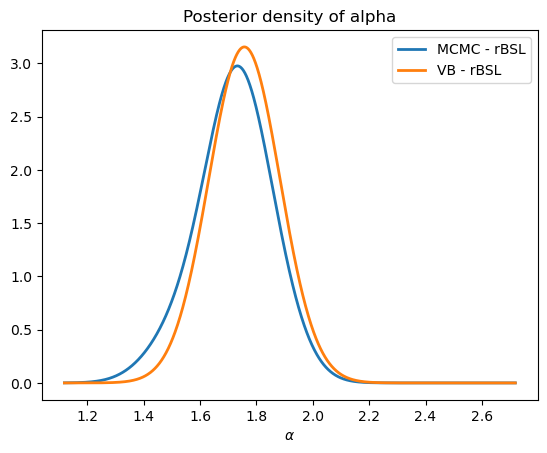

In [37]:
plt.figure()
pos_alpha_mean = np.mean(pos_w[int(num_burnin):,0])
pos_alpha_std = np.std(pos_w[int(num_burnin):,0])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_alpha_mean-6*pos_alpha_std,np.mean(best_alpha)-6*np.std(best_alpha)), max(pos_alpha_mean+10*pos_alpha_std, np.mean(best_alpha)+10*np.std(best_alpha)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.0985, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,0].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.125, kernel='gaussian')
kde_vb.fit(best_alpha.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 1.7, ymin = 0, color = 'black', label = 'True alpha')

plt.legend()
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

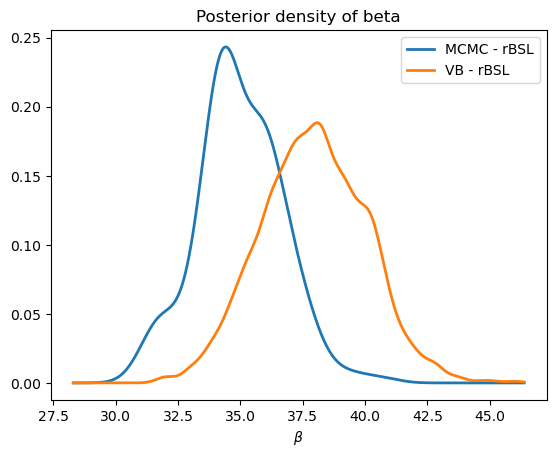

In [44]:
plt.figure()
pos_beta_mean = np.mean(pos_w[int(num_burnin):,1])
pos_beta_std = np.std(pos_w[int(num_burnin):,1])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_beta_mean-4*pos_beta_std,np.mean(best_beta)-4*np.std(best_beta)), max(pos_beta_mean+4*pos_beta_std, np.mean(best_beta)+4*np.std(best_beta)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.65, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,1].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.35, kernel='gaussian')
kde_vb.fit(best_beta.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 35, ymin = 0, color = 'black', label = 'True beta')

plt.legend()
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')


Text(0.5, 1.0, 'Posterior density of gamma')

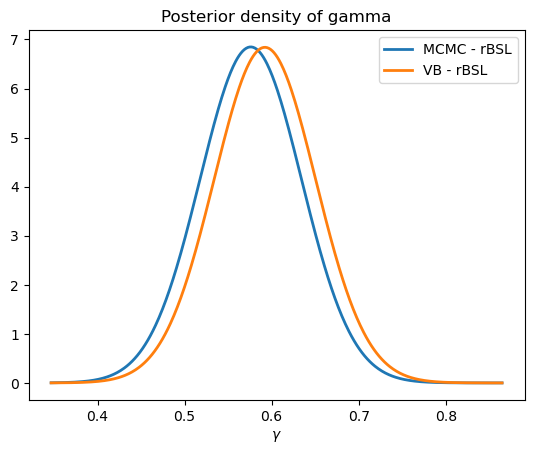

In [43]:
plt.figure()
pos_gamma_mean = np.mean(pos_w[int(num_burnin):,2])
pos_gamma_std = np.std(pos_w[int(num_burnin):,2])
#x_plot_mcmc = np.arange((pos_alpha_mean-4*pos_alpha_std), (pos_alpha_mean+4*pos_alpha_std), 0.002)
x_plot = np.arange(min(pos_gamma_mean-12*pos_gamma_std,np.mean(best_gamma)-12*np.std(best_gamma)), max(pos_gamma_mean+14*pos_gamma_std, np.mean(best_gamma)+14*np.std(best_gamma)), 0.001)
kde_mcmc = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_mcmc.fit(pos_w[int(num_burnin):,2].reshape(-1, 1))
y_plot_mcmc = kde_mcmc.score_samples(x_plot.reshape(-1, 1))

#x_plot_vb = np.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde_vb = KernelDensity(bandwidth=0.055, kernel='gaussian')
kde_vb.fit(best_gamma.reshape(-1, 1))
y_plot_vb = kde_vb.score_samples(x_plot.reshape(-1, 1))

plt.plot(x_plot, np.exp(y_plot_mcmc), '-', linewidth=2.0, label = 'MCMC - rBSL')
plt.plot(x_plot, np.exp(y_plot_vb), '-', linewidth=2.0, label = 'VB - rBSL')

# plt.axvline(x = 0.6, ymin = 0, color = 'black', label = 'True gamma')

plt.legend()
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')
 